In [148]:
import contextlib
import ipynb.fs
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import torch
import wave

from collections import defaultdict
from scipy.io import wavfile
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn import tree
from tqdm import tqdm

from .defs.formant_vowel_prediction import vowel_prediction, vowel_prediction_sd
from .defs.vowel_feedback_function import vowel_feedback
from .defs.extract_formant import extract_formant

In [2]:
folder = '../../allwavs/allvowl/extracted'
files = os.listdir(folder)

In [3]:
def trim_wav(in_wav, out_wav, start, end):
    sample_rate, wave_data = wavfile.read(in_wav)
    start_sample = int(start * sample_rate)
    end_sample = int(end * sample_rate)
    wavfile.write(out_wav, sample_rate, wave_data[start_sample:end_sample])

for file in tqdm(files):
    if file == 'trimmed':
        continue
    start, end = file.split('__')[2:4]
    start = float(start)
    end = float(end)
    trim_wav(folder + '/' + file, folder + '/trimmed/' + file, start, end)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1756/1756 [00:08<00:00, 218.88it/s]


In [4]:
v_files = os.listdir(folder + '/trimmed')
cnt = 0

vowels = defaultdict(list)

for file in tqdm(v_files):
    path = folder + '/trimmed/' + file
    with contextlib.closing(wave.open(path, 'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    try:
        f1, f2, f3, f4 = extract_formant(path, start_time=0, end_time=duration, f0min=math.ceil(3/duration + 0.000001))
        vowel, gender, start, end, phonemes, word, orig_file = file.split('__')
        vowel = vowel.replace('E+', 'E').replace('@', '9')
        if len(phonemes) == 1:
            phonemes = '_'.join(list(word.replace('1', ''))).replace('u', 'y')
        elif len(phonemes) == 2:
            phonemes = 't_E+'
        elif len(phonemes) == 3 and '_' not in phonemes:
            phonemes = 't_U~+'
        vowels[vowel].append([f1, f2, f3, f4, gender, phonemes.split('_')[0]])
        print(vowel, gender, phonemes, word, f1, f2, f3, f4)   
    except ZeroDivisionError:
        cnt += 1
        continue
        
print(cnt)

  1%|▌                                                                                                          | 9/1755 [00:00<00:21, 81.77it/s]

2 f s_2 ceux 438.81399558973044 1606.122945700775 2394.745896334599 3470.5905031364987
2 f p_2 peux 548.0696895893401 1489.944256015253 2580.0674570673004 2950.43017346328
2 f m_2 meut 357.1923610714844 1597.2973283691717 2214.9766661000276 3556.753383950201
2 f p_2 peux 501.7089972110503 1924.096321135514 2794.1825300616288 4118.474460644498
2 f p_2 peux 479.5305357429946 1538.8451944943251 2313.7282507425866 3431.320613617711
2 f p_2 peux 480.1673245962222 1702.6783620171543 2571.0940016270215 2963.7772815728476
2 f p_2 peux 383.56068812385166 1554.6895667502743 2137.1697304661857 3345.738979091854
2 f m_2 meut 405.04120235486147 1866.1743424201475 2708.843978773124 3997.3327076064106
2 f s_2 ceux 431.91787419050434 2129.0234771803944 2565.1480332070546 3403.8138325969753
2 f m_2 meut 450.0312026104178 1601.4291927690851 2427.7637918543846 3480.979157699424
2 f p_2 peux 381.2431162563888 1603.9617770915725 2247.3436150589414 3551.1232921205396
2 f p_2 peux 391.4229706752999 1344.0164

  1%|█▌                                                                                                        | 25/1755 [00:00<00:27, 64.00it/s]

2 f p_2 peux 448.38078643521607 1720.414974989505 2472.441147624177 3326.358157888279
2 f s_2 ceux 369.3938310839446 1582.6724448817347 2272.74517194704 3414.080211695936
2 f p_2 peux 370.3975027283071 1848.761644311133 2676.1085660935037 4003.842146611041
2 f p_2 peux 481.9732311010275 1615.1814094785589 2248.4351345727546 2733.1131159535403
2 f m_2 meut 378.21528898460673 1525.3203696289927 2151.671487112848 3555.323558120425
2 f p_2 peux 440.2544620002314 1565.8922854538694 2384.931194960794 3452.9862012114154
2 f p_2 peux 382.56291954154136 1773.0682737066904 2640.031515159359 3628.9517262759637
2 f m_2 meut 423.62975100040046 1667.197706571681 2168.7959364190124 2804.7450157744925
2 f m_2 meut 376.7171447977536 1575.0307167622636 2477.986573239655 3546.202023931425
2 f m_2 meut 455.2015242994197 1666.5309409166682 2328.0338980521205 3163.310118691152
2 f m_2 meut 351.05785858645385 1837.6918351912127 2685.766913609539 4003.5115307869114
2 f p_2 peux 471.09417322063524 1664.5382399

  2%|██▎                                                                                                       | 39/1755 [00:00<00:29, 58.14it/s]

2 f m_2 meut 327.47553839234314 1979.7384522508264 2693.8430310282743 3876.5286188896152
2 f s_2 ceux 363.5296882216824 1959.955912035105 2717.9680184874833 3812.486719118324
2 f s_2 ceux 382.7283028360042 1547.801599268236 2316.7189250180736 3435.9489622076703
2 f s_2 ceux 341.98942467210753 1588.2881125513284 2339.3580207892082 3539.130875515115
2 f m_2 meut 428.5413497787641 1700.5313850800317 2714.838348348036 3843.4524961065827
2 f m_2 meut 566.7549489092227 1674.437429971728 1941.225857657864 2664.761436707327
2 f s_2 ceux 395.46676345314205 1517.1755427950402 2356.9333456478107 3418.7996593296293
2 f m_2 meut 421.3859932514771 1336.7324242106695 2388.5170183326404 2966.925183596349
2 f s_2 ceux 458.71723082993435 1777.0593484829449 2680.309445050586 3935.4188148870944
2 f s_2 ceux 492.14674316834777 1687.3032221657304 2560.9369614135053 3774.7545476782266
2 f s_2 ceux 379.044329280053 1667.8755642853046 2551.9853785669598 3852.9099971021947
2 f m_2 meut 

  3%|███                                                                                                       | 51/1755 [00:00<00:30, 56.29it/s]

426.2309142167044 1644.8461113439685 2403.8128252200218 2881.84484827521
2 f m_2 meut 356.9444635400683 1214.7802832905766 2601.47624176768 3834.24616207335
2 f m_2 meut 423.07736808783625 1648.6275950364054 2404.8143431786752 3056.241804259003
2 f s_2 ceux 476.7240271724986 1594.8677237466375 2194.7954593394793 2715.550703806018
2 f s_2 ceux 493.96018535118293 1586.6781797384851 2213.378511979989 2722.9897066157896
2 m p_2 peux 425.3581928643435 1363.860655763009 2189.164352021019 3048.933081184568
2 m p_2 peux 427.80883244270416 1044.748723664176 2260.6431042049444 3425.753273468731
2 m p_2 peux 393.186186605092 1254.3783971187006 2175.0964470802983 3497.5805607008815
2 m m_2 meut 405.5100665787079 1245.0264156169446 2351.0279608750157 3355.3316606138865
2 m p_2 peux 380.8490029546903 1500.8280456551602 2260.928803268777 3296.706451507018
2 m p_2 peux 390.8585797603781 1347.6375332136697 2068.452232884187 3066.010622204814
2 m m_2 meut 413.0044532799244 1134.1488917228157 2335.422810

  4%|███▉                                                                                                      | 66/1755 [00:01<00:26, 63.61it/s]

2 m s_2 ceux 403.7696720473279 1247.1472284095853 2430.2584732780842 3348.2258080255456
2 m m_2 meut 391.8105287111027 1376.3820542437068 2251.0570447807745 3305.1484216211543
2 m s_2 ceux 395.6271769659731 1192.5479420338597 2287.001441126867 3352.265976471121
2 m s_2 ceux 417.9300786276827 1409.90212609973 2284.571033044251 3067.368321847619
2 m m_2 meut 397.68645282113005 1379.8001089911527 2052.177722732675 3042.405360345378
2 m s_2 ceux 359.97800776702525 1430.4733048591022 2462.997140220471 3087.5795211407067
2 m m_2 meut 392.3581754849275 1375.695538205565 2014.7077553978183 3012.8808647593573
2 m m_2 meut 390.15341040913376 1509.4774820964885 2262.436787639097 3288.871256217301
2 m s_2 ceux 370.20230917279963 1414.252479622261 2197.2783053309877 3097.4026753270546


  5%|█████▌                                                                                                    | 92/1755 [00:01<00:21, 76.51it/s]

9 f p_9_R peur 621.6365776499454 1796.3554059493974 3024.883147992519 4249.965377153433
9 f p_9_R peur 546.9437114887288 1806.4478011993654 2750.6687483758196 4049.872701480277
9 f t_9_R teur 536.3255897125861 1568.8136404367983 2410.9305060470865 3391.3863026657887
9 f p_9_R peur 596.8115881004597 1495.0235728589396 2429.196679227021 3607.5369907277704
9 f t_9_R teur 626.6956728264273 1704.9765636862398 2460.821612662424 3412.976393412702
9 f p_9_R peur 557.7897706812468 1644.9177354396109 2457.232815567976 2886.901556691792
9 f p_9_R peur 505.65353821419075 1520.0046777680739 2382.077662972831 3222.6043109624743
9 f t_9_R teur 554.33213528053 1376.6485544251561 2411.223593865967 2780.1643009875024
9 f t_9_R teur 501.09106285786754 1551.9112241217338 2421.5107843954097 3035.9625998509628
9 f m_9_R meurs 405.89194949502155 1833.968455809552 2087.1817317088344 3107.991716285014
9 f t_9_R teur 377.2440105071512 1859.7178000582005 2201.893025767925 3145.536741897551
9 f t_9_R teur 499.286

  6%|██████                                                                                                   | 101/1755 [00:01<00:22, 72.54it/s]

peur 530.6384945287909 1486.3456388962013 2459.7569368959007 3865.1619925656505
9 f t_9_R teur 526.1458727508647 1636.4419120938594 2460.9621546603416 3931.170814561456
9 f l_9_R leur 618.0664037515445 1481.194103225266 2422.4353076327893 3601.8190492386975
9 f l_9_R leur 568.7879747956248 1719.6688696052984 2709.0246574204507 2838.293985510215
9 f p_9_R peur 542.2472660324925 1548.066013542629 2346.18563552232 3569.479738137238
9 f p_9_R peur 599.2125916118846 1529.0668986778169 2001.0799916982044 2745.9458379808507
9 f t_9_R teur 621.7724774315006 1410.2056743837916 1865.3571666734579 2639.636284862616
9 f p_9_R peur 488.4029131335168 1335.3277930827007 2311.734217252976 2878.995877570414
9 f m_9_R meurs 491.5861736064091 1373.88377100271 2310.138956672353 2899.283460774596
9 f l_9_R leur 480.21160873767303 1523.3222216791855 2263.860674856272 3700.272072698937
9 f t_9_R teur 472.1812367799671 1375.2665716594975 2435.0431450529695 2908.090433997562
9 f t_9_R teur 509.2903737291207 15

  7%|███████                                                                                                  | 117/1755 [00:01<00:24, 66.92it/s]

t_9_R teur 659.6255309819146 1738.8172850480676 2629.6955612126394 4390.386035055002
9 f m_9_R meurs 576.6671414151733 1639.3315542681194 2559.3160156258277 2825.2105877595104
9 f m_9_R meurs 524.5216769800068 1519.7934028664574 2365.2219351144386 3572.7774376581838
9 f l_9_R leur 598.3088598643194 1524.7680091602513 2354.1764305796687 3534.1033380558165
9 f l_9_R leur 504.34131545362976 1592.4765451418978 2345.733177686345 3704.4134770421047
9 f t_9_R teur 581.3619908673095 1513.3493992360225 2217.1986303960084 3460.595952407045
9 f p_9_R peur 520.2049555918561 1563.5538526613218 2657.832622451917 3738.8551665287832
9 f m_9_R meurs 595.2467065785328 1439.3813818992323 1841.1755835413387 2815.2265178444463
9 f m_9_R meurs 566.0891203992179 1533.2367286323329 2446.981135704787 3588.9173681643542
9 f m_9_R meurs 406.7662635571013 1526.4354652342197 2212.596110044053 3309.4286653287613
9 f t_9_R teur 582.8746744273875 1609.9041188134936 1844.3447161607808 3081.605252497499
9 f p_9_R peur 

  8%|███████▉                                                                                                 | 132/1755 [00:01<00:23, 68.55it/s]

9 f p_9_R peur 641.4199719336873 1866.7682067086994 2967.5563020684517 4263.155543818589
9 f p_9_R peur 575.416714934259 1500.1459995714538 2436.1411501218086 3530.7638865339263
9 f l_9_R leur 485.6171671146007 1374.7598015319911 2348.2954702309503 2879.549573479093
9 f t_9_R teur 564.4355127271544 1636.4256446797715 2189.5526488894693 2567.097513662301
9 f t_9_R teur 565.9643619644315 1638.8346215209472 2163.1225382229786 2543.630148381791
9 f l_9_R leur 597.0045820150948 1637.7981189498435 2398.1145651242996 3736.8172843665993
9 f m_9_R meurs 584.3581865705248 1520.6867738842413 2427.7153840950405 3600.0895020458584
9 f l_9_R leur 522.1677209990122 1472.5600244277089 2068.3509776657634 2824.336333560372
9 f m_9_R meurs 566.5192529024617 1580.9776549544606 2700.4495690437466 3787.6092113764103
9 f m_9_R meurs 556.129302023361 1514.5449328392929 2426.1576867129943 3838.7832135337535
9 f l_9_R leur 527.6236635706357 1601.7775026284446 2716.07961900208 3768.985622822491
9 f m_9_R meurs 6

  9%|█████████                                                                                                | 151/1755 [00:02<00:20, 79.74it/s]

 meurs 552.9819802667116 1789.8449703931242 2441.746842805924 3388.896104979227
9 f l_9_R leur 596.8774644625373 1060.8470697965474 2084.0104985731055 3093.567210372124
9 f m_9_R meurs 521.0600374121047 1615.6952251447417 2036.2474175577072 2646.0686903037617
9 f m_9_R meurs 521.553957369177 1618.3449872944836 2067.2078124425507 2658.4781984561014
9 f l_9_R leur 575.7824814914065 1734.3202239151115 2217.380391874343 3700.21903305994
9 m l_9_R leur 502.4978047111444 1298.1745990433096 2487.6983860615737 3416.3951433739057
9 m p_9_R peur 499.6150792512423 1581.3269693889802 2421.643076777188 3251.517103214729
9 m t_9_R teur 500.73334729946254 1252.0895097801106 2522.263519152887 3366.607753633644
9 m t_9_R teur 464.29742937398 1581.4319741670079 2428.757157181681 3140.8582199805865
9 m t_9_R teur 505.7834016907301 1428.8147948795024 2336.706324471387 3136.5887903321877
9 m p_9_R peur 465.8192945898562 1427.280149163283 2295.7891743164632 3192.5501978774914
9 m l_9_R 

 10%|██████████                                                                                               | 168/1755 [00:02<00:20, 76.19it/s]

leur 500.8328951484274 1294.9981736483426 2470.0436989045143 3413.3720334327168
9 m p_9_R peur 487.6826272410211 1238.5159917654457 2485.277197385547 3498.026983426516
9 m m_9_R meurs 509.97085085242315 1247.5635031245074 2517.0374337096223 3421.4790319758076
9 m t_9_R teur 483.94691698881223 1288.0650547194227 2462.7250179904477 3362.957170090129
9 m p_9_R peur 496.2977925717267 1258.741041128709 2526.7927207436696 3461.220213352761
9 m m_9_R meurs 524.5123943017206 1190.6159890554175 2506.9775918756045 3351.803990346026
9 m t_9_R teur 473.3120828097726 1440.369942974127 2315.866694966795 3092.783962333532
9 m m_9_R meurs 487.55486084459164 1591.9430794882103 2426.1149829969345 3330.520260021145
9 m l_9_R leur 474.6005330571554 1519.1398118540167 2381.161848071089 3339.323145199054
9 m t_9_R teur 458.9366264062079 1489.260925944128 2286.819966589128 2866.5302955052134
9 m p_9_R peur 462.5572444283815 1415.6742374776022 2189.5940488725114 3100.2721770772737
9 m l_9_R leur 458.230198325

 10%|██████████▉                                                                                              | 182/1755 [00:02<00:17, 91.78it/s]

peur 468.19804885726205 1507.8098554396352 2384.506543201428 3178.0174457438516
9 m l_9_R leur 477.85357516590597 1461.3338260889307 2231.3801756004636 3212.2815413133644
9 m m_9_R meurs 458.5986943824976 1389.8944794656554 2223.536011688261 3138.6297069390603
9 f t_@ te 464.8937148854047 1598.977623351728 2451.230095793909 3507.236706234518
9 f t_@ te 451.5613715198663 1739.938753664548 2520.8354613236074 2845.837443105907
9 f t_@ te 500.1576399434198 1598.2978903126873 2421.158934492427 3199.1014599910604
9 f t_@ te 442.4796549948413 1663.101633025629 2462.4932486150356 2796.010310555475
9 f t_@ te 333.261689302391 1602.4283733462228 2677.8901938214804 3527.030466340492
9 f l_@ le 497.8739963607274 1601.9287638004682 2362.473910235546 

 11%|████████████                                                                                             | 201/1755 [00:02<00:21, 73.97it/s]

3646.898699598574
9 f t_@ te 379.63183949840834 1568.3127625709199 2439.320612770253 3525.182621680442
9 f t_@ te 575.4424522203376 1679.3858640517703 2300.729869467106 3243.9794571811594
9 f t_@ te 471.89197403957843 1611.5283274375288 2414.6968836015076 3723.7137513265525
9 f t_@ te 440.48641899536943 1683.3943588469956 2651.952609766397 4052.8354561978817
9 f l_@ le 502.36314635382723 1614.7711389987167 2256.5434803874673 3721.3184747586165
9 f t_@ te 391.95982681957656 1382.9850399781917 2669.531475523677 3079.396623126657
9 f l_@ le 439.1327308259312 1560.7049269406275 2341.2504575560865 3376.879625583627
9 f l_@ le 387.1706309152464 1630.858006068155 2589.0529705049157 2847.1729034003283
9 f t_@ te 573.247107212887 1689.4465579980968 2271.6987438461297 3217.748925840554
9 f l_@ le 376.72214160089595 1517.2395728358001 2325.5285225210287 3434.8960626540193
9 f l_@ 

 12%|████████████▋                                                                                            | 213/1755 [00:02<00:18, 82.66it/s]

le 340.07205942822065 1560.8996621099902 2633.160680515194 3735.952101878712
9 f l_@ le 405.65911847059004 1353.8599515456356 2273.998815501322 2874.8952101509735
9 f l_@ le 564.8787609831213 1795.5043314089514 2591.022166777893 3053.4221869517705
9 m t_@ te 366.4743779360667 1422.6173860842225 2445.5860841528333 3001.400825357151
9 m l_@ le 404.19183287661076 1309.140894696361 2300.021164784698 3398.3561476615323
9 m t_@ te 420.0179979480898 1231.278815233278 2325.1674411368713 3511.112976059003
9 m t_@ te 393.1291109732016 1280.0537183485387 2310.255837760621 3410.6246375674746
9 m t_@ te 408.93546206745054 1545.6756391447823 2244.880984383641 3202.036253174614
9 m l_@ le 425.2459435976504 1191.5473769313262 2232.7771407931255 3428.6574440449203
9 m t_@ te 380.0864741210345 1354.1323307786747 2073.5062419355877 2977.5540627372625
9 m t_@ te 405.9872067762762 1507.258144119827 2372.414164960185 3263.838641936605
9 m l_@ le 407.6784507405495 1347.9188504108263 2136.894340568741 3004.76

 14%|██████████████▏                                                                                          | 237/1755 [00:03<00:15, 95.82it/s]

374.82322393062844 1374.6327656718627 2112.255077607476 3069.8314905464713
a f t_a ta1 623.623118778097 1514.0368834339383 1784.5730423130358 2546.555584479068
a f t_a ta1 539.5650094440356 1601.9049085523677 1920.0096526870025 2833.0105784623765
a f t_a ta1 534.8153386382212 1852.2804680868787 2512.800164684308 3231.0734795330777
a f t_a ta1 647.0292471642296 1943.138794201888 2656.712513692427 3390.5731045360085
a f t_a ta1 600.2381910296646 1723.510180065663 2151.3759040641803 2856.4784130302496
a f t_a ta1 511.2748880333017 1907.592964965908 2788.647681345952 3755.1300362990905
a f s_a sa 689.687950326618 1292.728649094119 2457.2581787762424 3823.4548003787863
a f p_a pas 852.2997783893795 1453.6476854999369 1937.355197452241 2766.2680851167975
a f t_a ta 672.208612178875 1347.9797295365586 2278.3176173410475 3437.277259731477
a f p_a pas 685.8620181276324 1444.4057162516604 2851.047537849847 3556.246495153362
a f p_a pas 895.7434638779239 1555.40997444168 2908.4650227451993 4048.7

 15%|███████████████▍                                                                                         | 257/1755 [00:03<00:18, 82.16it/s]

a f t_a ta 624.3841792815731 1628.9807948678053 2442.3686299731517 3412.622433788961
a f t_a ta 885.0512971386848 1700.8703836619968 2917.1244702601207 4463.037439371637
a f t_a ta 684.5869912636576 1363.638216901436 2209.7950753747587 3060.902427970448
a f p_a pas 536.7307735561176 1335.6877300333315 1854.3171297120227 2958.4511278055616
a f s_a sa 654.8179012572161 1411.9275461796963 2206.0369221617075 3281.6374534244933
a f s_a sa 667.2541240170664 1264.254946045733 2346.2012927743417 3369.191110279229
a f m_a ma 628.2724463980621 1337.692439294979 2306.148146837657 3486.5288638606526
a f p_a pas 597.3532114949684 1202.6992508189376 2642.314148706428 3278.396539125179
a f s_a sa 764.9048823534389 1505.5898738458964 2449.3204705080234 2742.3010389374977
a f t_a ta 784.3308835409038 1609.0591063120464 2961.1757307125854 4244.38449812092
a f l_a la 703.4302555657207 1523.9176811507439 2032.253695160617 3269.1576326056315
a f t_a ta 576.1086009834369 1221.8414813456739 2584.819962037289

 15%|███████████████▉                                                                                         | 266/1755 [00:03<00:19, 77.56it/s]

s_a sa 809.6034446535255 1609.3385596793405 2909.3628639740364 4417.42654662633
a f l_a la 745.996174053061 1477.66037215328 2851.1056591638926 3704.6533641225697
a f t_a ta 670.173740000914 1443.288101804444 2787.4764907236217 3647.565848769731
a f l_a la 706.5629883789358 1404.2015924950986 2885.5970827688443 3889.962263582803
a f t_a ta 981.7773513060472 1548.314173641416 2654.387593099691 3846.302788680766
a f p_a pas 483.6738016982614 1278.7166607097106 2135.0904580178144 3337.380740737748
a f m_a ma 541.1799456453904 1595.6632209711142 1848.824449193563 3322.1502116072375
a f l_a la 487.2353387636513 1275.0096891224105 1953.4944658401637 3110.374631529409
a f p_a pas 1034.94228612713 1526.6543040247113 2750.5934191915912 3781.387587372012
a f t_a ta 655.2979661503724 1429.51640261161 2400.1858381918264 3539.209511510918
a f p_a pas 834.7493568740338 1454.1217461841022 1955.638391239913 2683.4164597742238
a f t_a ta 705.720731350442 1607.0288033232234 2206.223168393036 2547.428718

 16%|████████████████▊                                                                                        | 282/1755 [00:03<00:20, 70.30it/s]

a f p_a pas 795.3585659140995 1427.2267706347045 2985.7071125915677 3776.557472649085
a f p_a pas 463.6522030810539 1356.5602644043422 2393.1401981225495 3702.8820543749525
a f m_a ma 680.8530611784144 1408.3622305314225 1988.5701058317338 2986.2466359098826
a f t_a ta 704.8402841804128 1544.9538833994152 2112.9913711821255 2585.7563952224623
a f p_a pas 826.0427155208541 1473.2606663950078 2004.5783024808513 2823.1125281234567
a f m_a ma 474.07147563621817 1252.8572712867087 2074.708997447233 3236.3514589420843
a f s_a sa 801.6121602359792 1684.1477835271567 2951.086652933268 4139.984122631324
a f l_a la 458.36133210147057 1289.5812688017973 2417.606523492562 3447.005126203149
a f l_a la 839.2274082341587 1722.8149012876063 2410.032687407276 4192.802870769625
a f l_a la 788.5964441964278 1665.873107981182 2949.190746767028 4398.6555212406865
a f m_a ma 840.7627947182526 1646.0427387146513 2947.93337288833 4357.4459064778575


 17%|█████████████████▊                                                                                       | 298/1755 [00:04<00:21, 69.25it/s]

a f m_a ma 591.5514450585583 1188.4814477912812 2676.2318170302956 2898.3029025107744
a f l_a la 645.4770702487015 1252.246040411321 2664.0304741516466 3293.1181975151794
a f l_a la 1141.0132017111973 1567.8313339681447 2962.379542816284 4155.758266065688
a f l_a la 721.6741113994342 1604.6001351714244 2926.359702937431 4370.950530395405
a f l_a la 533.0555630180505 1537.7843914424086 2477.5622830789057 3854.25711255806
a f m_a ma 822.6686906707997 1304.0317256818971 2064.6886718503006 2893.253026445924
a f s_a sa 554.2233072595483 1290.5985613776368 2215.603500848702 3334.916193192695
a f m_a ma 605.1464872305345 1415.216490613971 2366.9651115760034 3535.975808487031
a f m_a ma 784.8240141890691 1361.4237420238528 2134.4972425552805 2705.3531923117657
a f s_a sa 702.6874092545206 1408.8755924062928 2685.5660905497866 3587.9320303419067
a f s_a sa 606.8114347922152 1401.4812519812654 2337.9755671568473 3625.398823102767
a f s_a sa 570.9281226910269 1202.1825674448573 2610.894354083162 

 18%|██████████████████▉                                                                                      | 317/1755 [00:04<00:18, 79.33it/s]

a f s_a sa 1247.8609369095693 1550.2936835626879 2539.459655747112 3909.726485451799
a f l_a la 810.4332100795586 1436.6934826697307 1972.878617042169 2509.5099616590787
a f m_a ma 1246.7315463356858 1572.7460198579454 2913.6177361189325 3910.0310960736438
a m t_a ta 761.0405064833494 1501.5802651374274 2220.7784547766823 3121.6576707085524
a m t_a ta 639.7899449507688 1334.1270144884238 2769.1916477627824 3464.3297012175076
a m t_a ta 715.6136579590676 1103.5613273349525 2325.774864475426 3198.379613813411
a m p_a pas 658.7667974067324 1214.3071900399104 2310.402035481052 3235.928073884654
a m p_a pas 681.7893370935193 1031.2884166346698 2360.2301306065597 3184.359547637906


 19%|████████████████████                                                                                     | 336/1755 [00:04<00:16, 84.67it/s]

a m m_a ma 719.986473287176 1051.5326999135978 2406.7226733593925 3262.77831479574
a m p_a pas 637.8480344075724 1264.7027672388288 2285.507143626573 3809.1364709491063
a m t_a ta 631.4755946774184 1361.684673641775 2597.2325536135213 3833.0408536430064
a m l_a la 708.8897736708111 999.4448133764971 2390.6759545657824 3030.5026730400273
a m m_a ma 661.7195605902834 1269.9290797004253 2496.6614198928396 3388.389200397146
a m s_a sa 623.0270224892432 1297.1490738291666 2515.244469817917 3706.723259997872
a m t_a ta 756.0125256740396 1399.3972478602466 2458.2064051676557 3273.427648134311
a m s_a sa 695.7410623008093 1309.3599214798076 2101.664310695462 3388.9284085125287
a m s_a sa 672.0219674656234 1022.400670309586 2326.1561929066584 3249.4427837192316
a m p_a pas 696.2429316448727 1310.8834895199673 2405.80922987121 2977.1217386159547
a m l_a la 628.8449825506908 1313.4788143953413 2430.594441912209 3862.519684774488
a m l_a la 774.9240856300557 1403.3289761865608 2449.869843520157 30

 21%|█████████████████████▍                                                                                  | 362/1755 [00:04<00:13, 106.14it/s]

a m s_a sa 757.8078112795297 1448.3581251467153 2488.8753001765926 3595.8714433108803
a m s_a sa 624.8694962316082 1337.6998333524812 2593.8947945902196 3480.682300259734
a~ f p_a~ pan0 558.4771898367767 701.1536230045942 2278.1350747963475 3366.0102578631822
a~ f t_a~ tant0 551.18023864999 877.1834232242483 1729.2956111792455 3213.7614318122646
a~ f p_a~ pan 470.7486285745553 1194.6686203027089 2213.811597130318 3511.094855874778
a~ f t_a~ tant0 544.8680966909441 1089.9699646210279 2469.0179982918385 2955.10479882578
a~ f t_a~ tant0 755.7627163961129 1813.2488549109094 3028.2074185772294 4383.825951913604
a~ f t_a~ tant0 686.2694781780876 1271.006079199779 2204.0183241481095 2773.6407982707906
a~ f p_a~ pan0 639.0123110373839 969.4026803304889 2516.151440327088 3257.9775969196126
a~ f p_a~ pan 671.030098574684 1360.9725863202952 2830.234262017798 3884.098475616147


 22%|██████████████████████▊                                                                                 | 385/1755 [00:04<00:12, 107.68it/s]

a~ f p_a~ pan0 663.0432053063593 924.9496230542676 2113.4719770909146 3284.5851974301095
a~ f p_a~ pan 653.9646091978022 926.5145615883462 2285.7185436751042 3484.9988883978526
a~ f t_a~ tant0 557.1871756088502 1139.7042914272463 1378.0288775434242 3531.4068408516237
a~ f p_a~ pan0 392.60292872799624 1456.6888937961537 1951.9918703503552 3384.3137762222195
a~ f t_a~ tant0 583.6263639899743 1001.0635698634419 2159.129029935722 3304.473123171337
a~ f t_a~ tant 518.4933112878996 1470.8107617797257 2501.4056247175713 3786.7587204508795
a~ f p_a~ pan0 533.6677061548224 1095.2895718301324 2834.08667622454 3705.181919210804
a~ f p_a~ pan0 427.37403074797027 723.0027394751145 2025.5382517960027 3463.077577085595
a~ f t_a~ tant0 553.2121534940172 872.9092973822671 1958.7509408147625 3133.813584341796
a~ f t_a~ tant0 588.0428203892416 918.508584255091 2060.395043564955 3107.11565976288
a~ f t_a~ tant0 588.0708007870521 1049.1349525906437 2168.2705594539225 3443.4596150765938
a~ f p_a~ pan0 428.3

 23%|████████████████████████▎                                                                                | 407/1755 [00:05<00:13, 98.38it/s]

a~ f t_a~ tant 346.48915702839514 907.6122294435146 2116.778290937417 3439.760442374379
a~ f t_a~ tant0 572.0304243284762 1250.699243154835 2887.2085173048563 3711.460742528354
a~ f t_a~ tant0 525.4880075587612 1200.0905071752154 2623.704962994496 2922.38846589894
a~ f t_a~ tant0 740.925889174922 1379.4211036476813 2830.017927768152 3445.5795881198455
a~ f t_a~ tant0 718.9608067017454 1212.9147987864926 2135.470770460347 2847.388185881381
a~ f t_a~ tant0 689.5855031631643 1039.9057334669003 2225.1464003641695 3218.3815990886837
a~ f t_a~ tant0 577.2277414401109 867.7815122491185 2074.995029397161 3282.1720143428743
a~ f p_a~ pan 394.39739928099783 949.7798817530276 1922.8121954229462 3294.9508263780244
a~ f t_a~ tant 402.20379328062154 846.189361958639 1855.75722232061 3304.7642141074652
a~ f p_a~ pan 552.6493759850683 1017.1885481694975 2355.0287897406934 2969.1567546228616
a~ f s_a~ sans0 612.6532953891438 1348.8258683602883 2648.3586975764324 3571.8429121971117
a~ f p_a~ pan0 756.17

 24%|█████████████████████████▌                                                                               | 427/1755 [00:05<00:15, 87.97it/s]

a~ f t_a~ tant 526.5916253393368 1418.0928041392044 2771.250569414552 3786.7911962450225
a~ f t_a~ tant0 614.0438437119553 1349.222749084924 3027.0562491523406 3478.900715581638
a~ f s_a~ sans0 547.3212524897529 1440.9571388109619 3134.4291644652885 3652.5221612848413
a~ f m_a~ ment0 749.5235615149356 1144.6353791551671 2206.1656609078354 3194.4382479575183
a~ f p_a~ pan 657.8264309069291 1448.6014811956095 2316.125216796259 3517.1156405956795
a~ f p_a~ pan 541.3933682018899 1553.728888513124 2580.301063797532 3781.325860651348
a~ f t_a~ tant0 622.0977748302006 1462.2139859251572 2999.0651695607025 3514.558364764755
a~ f p_a~ pan 533.5541755138648 1331.3947716897076 2413.2910213711757 3592.1471626836087
a~ f t_a~ tant 471.7995522104677 1259.3106390875084 2376.1901524507566 3609.915424297618
a~ f p_a~ pan0 475.35306483591916 827.7513901368704 2121.077444445786 3333.690686769392
a~ f l_a~ lent0 729.7047595749455 1262.7914511244605 2155.711119819886 3194.8904303850163
a~ f t_a~ tant 610.0

 26%|██████████████████████████▊                                                                              | 448/1755 [00:05<00:13, 96.36it/s]

a~ f p_a~ pan0 570.7242711248947 1054.1960823596075 2507.205063291967 2959.300412588447
a~ f s_a~ sans0 166.92631679984467 838.8522210134072 1921.3984754566404 3372.151286692031
a~ f l_a~ lent 637.2043214640511 1126.1428520565362 2585.900713265363 3931.4280745687774
a~ f t_a~ tant 386.26494446538936 1016.2270062914048 1908.1742331917117 3314.4223889313453
a~ f p_a~ pan0 504.0209321105705 996.2802498649672 2387.271339257834 3427.76589346604
a~ f p_a~ pan 386.20499448023963 1383.5200131039314 2224.93298099379 3617.5740721205993
a~ f l_a~ lent0 615.3517039467913 1443.1768905266847 2375.7098862472903 3371.8679863067346
a~ f m_a~ ment0 634.0827308877874 1372.8791212464298 2432.6680695062796 3821.5306133083204
a~ f s_a~ sans0 547.4433166571417 921.7715277288326 2302.10129038422 3482.2106060158535
a~ f m_a~ ment0 520.1488517783839 835.389150110369 2247.1385029059757 3605.77484311647
a~ f t_a~ tant0 744.0107702396173 1349.6548667326865 2253.975849057445 2813.2392853786887
a~ f l_a~ lent0 528.2

 27%|████████████████████████████                                                                             | 468/1755 [00:05<00:14, 88.09it/s]

a~ f t_a~ tant 595.0475284922943 1076.1382779658018 2202.693136903588 2741.623740013883
a~ f m_a~ ment 444.3426201370726 1054.7254205383222 2123.83438402506 3338.9044388544485
a~ f l_a~ lent0 560.4914809122602 1021.1962340782891 1408.9815151799453 3230.508256797287
a~ f s_a~ sans0 541.8930778580243 917.2467697142225 2154.434148627018 3415.1439795321817
a~ f s_a~ sans 474.2038094985423 1186.4208457198818 2295.1580298327463 3705.8133249153834
a~ f s_a~ sans0 791.1138653645787 983.3430605769848 2211.1482958150514 3206.305446551533
a~ f s_a~ sans 375.1144328660347 962.0388664979839 1840.5054374443073 3297.2489393567835
a~ f m_a~ ment0 673.2254645551117 1438.1936508110628 2302.371465599579 2828.572886532379
a~ f m_a~ ment 585.3965371902741 1155.2795526679904 2279.6771576649 3412.0845759924587
a~ f p_a~ pan 536.0864374849513 1189.2129164266416 2327.715661480613 3156.4839893258313
a~ f t_a~ tant0 380.68918031649406 1588.6696907368214 2360.3891580071845 3611.1210911408434
a~ f m_a~ ment 321.08

 28%|█████████████████████████████                                                                            | 486/1755 [00:06<00:15, 82.73it/s]

637.5379958748221 1541.7854589012902 2881.1285322219 3950.559459306479
a~ f t_a~ tant 588.2976839899878 967.7621814736805 2156.6467831017544 2690.9699061066444
a~ f s_a~ sans0 609.1646207107223 978.3287836055165 2217.471835279373 2975.835987323935
a~ f l_a~ lent0 535.6945552153817 801.9847916651235 2198.283663390147 3311.36169432077
a~ f s_a~ sans 305.48335806516826 866.4512775675518 2133.665154783138 3367.7863385210803
a~ f l_a~ lent0 629.7643521372669 1307.392006957006 2598.44003095976 3343.956672723339
a~ f p_a~ pan0 654.7779919991945 961.4319815266957 2147.5909418869805 3289.5489044627666
a~ f p_a~ pan 487.51013739234537 1135.1134733047195 2306.146063076835 3138.062703830325
a~ f m_a~ ment0 610.0942025229494 1356.999161310365 2913.5353599806313 3815.0152188236207
a~ f s_a~ sans0 284.2272336541052 1719.7527813546956 2696.7917288667322 3579.2995689612976
a~ f s_a~ sans0 775.8011966587497 1809.3429162516902 2952.76834256265 4094.34015871696
a~ f m_a~ ment 431.8219229333329 1009.054230

 29%|██████████████████████████████▏                                                                          | 505/1755 [00:06<00:14, 85.51it/s]

ment 631.7174719387812 1190.59658608166 2834.1473084890986 3813.8424870256513
a~ f m_a~ ment 550.237427128797 913.0045940403722 2453.8595167557464 2914.2890854805487
a~ f m_a~ ment0 630.5510890503076 1028.718416938343 2265.010842447848 3308.883497947359
a~ f m_a~ ment0 488.75872501523173 973.6372810456787 2215.1115774692007 3644.40238988927
a~ f s_a~ sans0 615.4426236155691 1350.6027752457696 3020.885091749082 3597.6464939235557
a~ f l_a~ lent 397.1109233129313 1121.8752686864486 1815.5169038551833 3216.7201824054528
a~ f s_a~ sans 542.9450285440338 1435.7907642956345 2807.262232775294 4043.59620130261
a~ f l_a~ lent0 534.6043459455856 1426.403169246739 1747.2598813450913 3169.435958369439
a~ f s_a~ sans 401.21861656026357 926.8103124144606 2174.136252476471 2939.5799717768027
a~ f m_a~ ment 614.2463142812052 1506.277847393851 2726.0053102880975 3865.157071126393
a~ f s_a~ sans 661.6416637985672 935.2339406627618 2268.907811091718 3305.1128465937004
a~ f l_a~ lent 564.7912521094389 116

 30%|███████████████████████████████▎                                                                         | 523/1755 [00:06<00:16, 76.83it/s]

366.56791595540886 1023.6338880250204 1903.8479037378377 3390.9291135739177
a~ f s_a~ sans 571.743407199642 1093.8903335546975 2614.181770881592 3781.7283884191884
a~ f l_a~ lent 356.3142072722232 1351.2134948601063 2419.049693906183 3586.8158078847105
a~ f m_a~ ment 425.7807074488987 1101.9007339007906 2395.311260804498 3568.818610244533
a~ f l_a~ lent0 668.1481547596226 1100.0048376384766 2489.8086020602154 3274.6865023928012
a~ f s_a~ sans 525.4133245107743 657.9175418227321 2244.3390502769153 3353.955008579326
a~ f s_a~ sans 586.5382671847311 1584.3265248141702 2704.569941030569 3871.818965973777
a~ f s_a~ sans0 777.8079276212047 986.5295191473294 2208.341808026381 3213.542994761847
a~ f m_a~ ment0 666.0218155566336 1289.4347721851288 2237.309846782774 2830.2808314556905
a~ f l_a~ lent 267.72396477161095 797.7517088845366 2148.2502534129935 3376.737361379347
a~ f s_a~ sans 634.1504131124341 871.8222410473471 2176.877862994251 2838.604880401042
a~ f l_a~ lent 651.8275007414786 1494.

 31%|████████████████████████████████▌                                                                        | 544/1755 [00:06<00:13, 87.51it/s]

a~ f l_a~ lent0 734.5581394321317 996.6365139355389 2135.0732294569675 3063.9748331148335
a~ f l_a~ lent 521.8372921198613 851.5017242396193 2194.5575253390107 2890.576126864841
a~ f l_a~ lent0 724.6722036649718 1016.6966357868731 2132.6404274764354 3032.470988711062
a~ f l_a~ lent 567.6130726201222 866.0176423966213 2171.429899754308 2872.7945512473393
a~ m m_a~ ment 594.8733198664272 1128.5691620973228 3006.060225074694 3594.649329185107
a~ m l_a~ lent 598.8172673610267 1225.2998768455366 2749.4400368460488 3440.4633659225615
a~ m t_a~ tant0 549.2525012467864 894.5502394217184 2943.509952753669 3487.4455594459323
a~ m t_a~ tant0 596.8353473140404 775.6938994684134 2289.533393385404 2944.628590303557
a~ m p_a~ pan0 531.0148456562714 827.6548271725851 2407.170745203168 3167.0067493743686
a~ m t_a~ tant0 542.2944706047134 1086.9303415557267 2583.6976309427714 3015.408587428024
a~ m t_a~ tant0 511.67686283145486 865.0583168007552 2094.316605394996 3080.542230020115
a~ m p_a~ pan0 573.164

 32%|█████████████████████████████████▋                                                                       | 564/1755 [00:07<00:13, 88.47it/s]

a~ m t_a~ tant 537.5126426012083 1303.7732955898998 2840.865032944324 3566.400955080146
a~ m p_a~ pan 516.6924731887642 835.5518838363454 2175.9319088120183 3110.8242183747175
a~ m t_a~ tant0 474.84149719834437 1254.719324537476 2488.738398649408 3080.1275908157195
a~ m t_a~ tant0 592.7429059493069 964.6257064723853 2368.1864438180387 2929.2004545824616
a~ m p_a~ pan0 544.6399015524677 955.275845508378 2602.9086663352723 3019.3808599999857
a~ m p_a~ pan0 557.9076014601781 853.9793381866839 2221.4073111936414 3037.3192569268417
a~ m t_a~ tant0 633.6646962161531 1011.4514637400007 2503.135302289108 3503.5194810629464
a~ m p_a~ pan 553.678578047966 912.8142504036408 2675.864747862272 2905.6354294737534
a~ m p_a~ pan0 552.531151658109 855.9968668172522 2847.370054802843 3358.352056840766
a~ m t_a~ tant 510.92785315854576 1001.5325315315893 2281.5593825693686 3116.206831984912
a~ m t_a~ tant0 526.8437133822667 1177.8784959675772 2545.867382334485 2984.147421501947
a~ m t_a~ tant0 522.173605

 33%|██████████████████████████████████▊                                                                      | 582/1755 [00:07<00:13, 84.60it/s]

a~ m m_a~ ment0 561.3271015294121 887.9751708822594 2553.8964089682304 3212.667426971912
a~ m l_a~ lent0 550.1389428524232 888.4708426806266 2514.0256236683763 3089.842194994783
a~ m t_a~ tant 545.2995339778577 1060.3836227319773 2568.9257190610183 2978.658035005641
a~ m l_a~ lent0 572.3890229062936 929.8861958185265 2778.5896195866785 3420.6810021606566
a~ m m_a~ ment0 544.3266666156512 881.823932330672 2774.6447994111095 3271.203214648627
a~ m m_a~ ment 509.1319555675671 792.3942729767807 2086.730595668153 3162.890018109126
a~ m t_a~ tant 542.7243917866374 1093.984598404102 2298.720052608554 3275.4749169201696
a~ m m_a~ ment0 494.90656445498894 1183.3557280056857 2550.6368826695584 3452.0598368704395
a~ m s_a~ sans0 500.6963203912993 892.1631398955615 2074.985179568418 2959.964248017102
a~ m s_a~ sans0 560.0192038822632 883.175181307598 3012.342758893937 3273.860919561401
a~ m l_a~ lent 538.657927898925 852.6601312821434 2631.4441733445888 3158.2932390922933
a~ m p_a~ pan 543.1351642

 34%|███████████████████████████████████▉                                                                     | 600/1755 [00:07<00:14, 81.92it/s]

 lent 503.41341322070963 818.7134734847632 2127.939638629901 3130.7264785999237
a~ m l_a~ lent0 503.42276903642204 836.288757355979 2485.4794327654563 3203.7051253784143
a~ m l_a~ lent0 562.3273183769048 1120.631540730525 2610.782922892688 3107.722022576084
a~ m s_a~ sans0 531.7485343506216 1210.9623380275907 2667.473529163564 3109.2908262812844
a~ m s_a~ sans 516.2526162322487 1184.9140640574772 2820.6946611581293 3128.26929917861
a~ m s_a~ sans 479.31754466692036 845.250489895792 2152.8498797576067 3046.0995822529694
a~ m l_a~ lent 563.8167312445671 1090.6577164798257 2401.9553863097494 3575.5452236802766
a~ m m_a~ ment0 530.8764728462043 1448.4509133369838 2824.943136089927 3959.3465531956886
a~ m m_a~ ment 591.5031686620945 1529.8801018730717 2824.648805090242 4121.335067760298
a~ m m_a~ ment 376.0905820159958 890.0774950748284 2190.14803431976 3378.1077903515425
a~ m s_a~ sans0 494.1914616313841 903.2685095018345 2084.056130070709 3233.6912054390755
a~ m l_a~ lent 533.194641026164

 36%|█████████████████████████████████████▎                                                                  | 629/1755 [00:07<00:10, 110.42it/s]

E f t_E+ taie1 213.33874445005094 1633.3310560081222 2587.827975780358 3669.839670924179
E f p_E+ paix 471.0647602071251 2331.3909262755205 2775.3333070942936 3115.9184219813633
E f p_E+ paix 531.5757384768452 1213.6540980593895 2337.633472756874 3312.473554212077
E f p_E+ paix 470.22317222693766 1983.556436580559 2275.8744975189697 3353.218645797659
E f t_E+ tes 461.6249384413681 2006.7442327901788 2644.8016255010957 3161.0467197982925
E f s_E+ ses 529.9716256938768 1729.9163671010272 2082.005972298784 2756.8151266806326
E f p_E+ paix 408.82494910514066 2330.942936230316 2893.472027687208 4017.668938823968
E f t_E+ taie 482.47526691839954 1850.0121217673027 2514.470559495163 2854.2076745550266
E f t_E+ tes 483.17699728881905 2482.9954549234076 3242.805764058267 4285.569285683607


 37%|███████████████████████████████████████                                                                  | 652/1755 [00:08<00:13, 83.30it/s]

E f t_E+ taie 536.4618897913546 2388.8065229681342 3211.91416856883 3864.381752796175
E f t_E+ taie 455.48658395933035 2018.216014841152 2611.147354612444 3493.9136276760164
E f t_E+ tes 510.68480150147434 2117.284419775239 2699.40485187169 2766.148744971668
E f t_E+ taie 420.652592102833 2323.5715443679596 2889.4250598117083 4474.883889171865
E f t_E+ taie 457.0299179468863 2295.955041916748 2753.4142454176185 3471.863598960474
E f t_E+ tes 429.69925613818265 2285.8015739730026 2860.730476581851 4076.4461983159704
E f t_E+ tes 514.6238984116382 1865.4048369845782 2642.577523206862 3350.3727674434062
E f p_E+ paix 475.30336474861804 1910.287446446722 2564.44963220444 3326.699444831078
E f t_E+ tes 368.4762868436237 1982.3333317553193 2684.249206443345 3230.302272090836
E f s_E+ ses 445.04342857560187 1975.178422723835 2539.601178822803 3364.103363945833
E f s_E+ ses 393.95486453197793 2344.9923027053364 2849.2686831832416 4187.110754944222
E f m_E+ mes 396.89203482120865 1932.565733976

 38%|███████████████████████████████████████▌                                                                 | 661/1755 [00:08<00:14, 75.90it/s]

E f p_E+ paix 368.3459022894974 2498.4656683230724 3157.8336298854906 3793.3883196334355
E f t_E+ taie 443.7191529346545 2165.0292216844446 2663.6756812536296 3640.605565969695
E f p_E+ paix 435.7259841296873 2482.7124657049844 2953.438096422402 4287.92786588374
E f l_E+ les 397.37083063454764 2043.53402610737 2627.1721979706344 3509.5694800428014
E f s_E+ ses 376.77091575118436 2564.713451512004 3272.4601366812335 4239.548462266168
E f t_E+ taie 390.4113138806092 2370.4071339886254 3136.400632845795 3961.6242105705483
E f t_E+ tes 437.2550228909126 2019.7569054692779 2722.041974924797 3286.773497809006
E f t_E+ taie 485.7339334012493 1969.1844152329236 2656.244520912868 3775.4928708369953
E f t_E+ taie 414.2505426559661 2024.6528462972715 2754.8115597603146 3697.180411569076
E f t_E+ tes 403.96840111668394 2199.1454681521827 2704.0043099587638 3535.103592706711
E f t_E+ taie 501.263822401821 1742.7151168963278 2228.7944964945996 2887.54842892504
E f t_E+ tes 309.61772573206525 2330.38

 38%|████████████████████████████████████████                                                                 | 670/1755 [00:08<00:15, 68.56it/s]

 432.68151588591735 2091.133118270827 2922.4125076925293 3738.4986672034524
E f t_E+ taie 320.0286128645801 2269.210913742221 2970.6523223321997 3643.675289801882
E f p_E+ paix 376.0363501613188 2361.010161470238 3182.7735089902953 3715.6853071977
E f p_E+ paix 475.1819636824751 1917.6699616121675 2737.025820546454 3501.168030004343
E f p_E+ paix 392.1802218883475 1902.4800859572929 2685.2388628019917 3070.318004313076
E f m_E+ mes 435.44251329108556 2706.9043704176943 3449.716856570028 4128.459927702005
E f l_E+ les 448.0494915428374 1938.2912397153057 2770.642946555646 3452.065623943016
E f l_E+ les 389.16558303467264 1669.5703478043215 2555.857557499084 3158.3802823700557
E f m_E+ mes 408.863167948257 1988.6252333411237 2624.9689198800907 3329.9303561095576
E f t_E+ tes 350.6714585588002 2081.2160441354304 2804.0049024273544 3439.7536024400074
E f t_E+ tes 437.3065419993769 2055.9418300784596 2848.050921783272 3700.700859338616
E f m_E+ mes 429.45950108852446 2066.876522876016 2841.

 39%|████████████████████████████████████████▉                                                                | 685/1755 [00:08<00:17, 61.30it/s]

E f l_E+ les 420.5376181728666 2400.4356389776162 2840.565886075394 3868.7714446470754
E f p_E+ paix 423.29136943849124 1964.9875642275272 2810.9469698816215 3697.778396745962
E f t_E+ tes 522.8681246635896 2174.719732012747 2624.6257150833944 3744.0836934673525
E f p_E+ paix 617.5598726660414 1711.4208292888704 2388.648950067171 2944.349451869562
E f m_E+ mes 439.7080276988949 2426.376975134424 2907.1511442079427 3976.3032753082
E f p_E+ paix 456.204966211144 2243.5612089469564 2583.5302159190537 3114.3489484542542
E f t_E+ tes 519.2521815238828 2142.201987918083 2593.9101388907984 3671.6439335621394
E f t_E+ taie 502.2815244172921 2196.6769042749647 2593.8088878620565 3575.453235617925
E f m_E+ mes 357.2888917206671 2065.6926207697916 2914.126803499194 3739.441508695578
E f t_E+ taie 489.73923386015775 2042.5510260862566 2588.1238926344317 3610.6974682366276


 40%|█████████████████████████████████████████▊                                                               | 699/1755 [00:08<00:17, 60.07it/s]

E f l_E+ les 396.8999616039265 2111.641211977462 2868.5344545574194 3614.338877106386
E f t_E+ tes 410.348846010557 2153.797548276584 3012.505387487071 3790.610091705973
E f l_E+ les 418.55931717946305 1501.4466994064771 2488.7770022034515 3169.709949319143
E f l_E+ les 404.1032615947161 1763.6014457859274 2626.634399111898 3744.2161806166296
E f s_E+ ses 383.8757771278014 2013.4152965980168 2663.591743455878 3268.905723493448
E f l_E+ les 293.626795116939 2044.7629785826587 2971.714285846014 3535.6292049685617
E f m_E+ mes 405.36233884127165 1442.3323658760764 2739.085054160537 3554.3257628550386
E f s_E+ ses 402.20951974097824 2065.936675565901 2918.961897827463 3773.196410997428
E f m_E+ mes 639.9254868491153 2098.413643860515 2210.1832979920555 2785.468708813901
E f s_E+ ses 418.92087707105264 1964.074517476973 2615.672415101008 3713.165388485286
E f s_E+ ses 412.737315402992 1752.0426391804112 2641.3524750016422 3396.546918933062
E f s_E+ ses 385.41187212791726 2438.1244422308346 

 41%|██████████████████████████████████████████▋                                                              | 714/1755 [00:09<00:17, 59.27it/s]

E f m_E+ mes 446.5180588220279 2308.768619640174 2791.3169739725586 3799.143684001985
E f l_E+ les 388.0426697697446 2096.7922579298743 2723.6550380954645 3067.7776387881963
E f m_E+ mes 502.01983314355033 2071.3434130372325 2620.280076255688 3678.357377146966
E f p_E+ paix 446.2618509038249 2246.8314959652394 2607.61456774577 3150.7438280013116
E f s_E+ ses 499.932818529458 2106.276216609897 2521.1968703309885 3555.5048553282027
E f s_E+ ses 494.3604995326122 2081.525645276834 2572.7539511720634 3685.0163655228616
E f m_E+ mes 504.91235811984814 2111.2926925025745 2613.8668770072577 3679.2052152732754
E f s_E+ ses 356.28042785060376 2146.5354716245547 2738.3863620205843 3548.42221033597
E f m_E+ mes 424.9865532637262 2002.7220137324466 2724.842902631686 3383.6925108352184


 42%|████████████████████████████████████████████                                                             | 736/1755 [00:09<00:12, 82.40it/s]

E f l_E+ les 450.7053495967257 2194.8790762427084 2505.341092137616 3206.2830804254486
E f l_E+ les 419.1201535421578 2362.961256684344 3100.1207290580933 3673.311204406091
E f m_E+ mes 359.9518025797424 2340.486009566873 3167.182695308958 3812.1563029894114
E f l_E+ les 449.74254805646495 2148.5083086418936 2466.7224746213938 3098.8317695865576
E f l_E+ les 418.19127420123374 1517.0298597450685 2862.754788580132 3666.384994189402
E m t_E+ taie1 1373.658046112174 2024.6547175860662 3224.268373022978 4007.772194309499
E m m_E+ mes 411.3929161964841 2006.6872511698818 2951.4199171919286 3507.4528018010037
E m t_E+ taie 433.47315017323035 2057.9382420452807 2531.9079725244765 2897.329477950202
E m t_E+ taie 468.20957893823976 1655.306320055126 2488.699831191711 3285.0759255710946
E m t_E+ taie 500.415827405184 2167.61862922137 2592.6527426835128 3366.7108539974874
E m p_E+ paix 498.72681816498624 2148.773125799446 2661.441036037695 3447.3074661829164
E m 

 42%|████████████████████████████████████████████▌                                                            | 745/1755 [00:09<00:12, 81.44it/s]

p_E+ paix 473.20006261088474 1985.528267652687 2205.821799222882 2932.6844737858546
E m t_E+ tes 388.1731808791587 1772.7808984452945 2457.324923619458 3136.709129509453
E m t_E+ tes 440.11891328093554 2067.874190517478 2665.6786092529555 2959.8834584177457
E m p_E+ paix 507.3583788589977 1634.8772245146465 2434.4765414160256 3172.783322763781
E m t_E+ tes 403.68993352292125 2108.2750724897755 2854.847163494484 3471.4176253444184
E m t_E+ taie 492.49275438877186 1250.1511609997517 2508.167943503182 2808.9688006478837
E m t_E+ tes 396.36755329542007 2075.212742649443 2509.901716578955 3102.468441741129
E m l_E+ les 390.4597376880949 2223.3151133221636 3017.8678408743845 3598.355818083028
E m t_E+ tes 379.18976208075657 1755.9698804493519 2411.598041388604 3156.152079362969
E m l_E+ les 419.7489295777016 2178.107362472313 3041.02971109156 3609.002324508237
E m m_E+ mes 447.2907542737341 2295.19362562517 3145.7144981110782 3600.26390021304
E m p_E+ paix 456.1766188115092 1691.485440331486

 43%|█████████████████████████████████████████████▋                                                           | 763/1755 [00:09<00:12, 79.92it/s]

E m s_E+ ses 409.96220210962275 2192.822894403981 2827.7670240001567 3558.9531228193973
E m s_E+ ses 391.7409260182155 2112.2455253060816 2793.386463231553 3379.782215940124
E m l_E+ les 405.5148795617412 1908.2149001259063 2197.6240335116286 3067.486758698272
E m m_E+ mes 405.1401303151895 1626.4097459901113 2162.01393272361 3179.811946474757
E m m_E+ mes 402.5349475557522 1798.1725657207446 2563.253103893082 3156.871605569397
E m s_E+ ses 405.7046031398888 1685.9457774505743 2505.849630251482 3174.260827316549
E m s_E+ ses 420.7880956349226 2028.5089948941054 2779.9976567122485 2996.211577953704
E m l_E+ les 387.3793650591006 1766.4760471815378 2466.8310781749765 3138.6216526749645
E m l_E+ les 353.75440993280813 1806.663059085299 2488.4983889375285 3243.7980150520593
E m l_E+ les 361.7038324084946 2021.1393054373762 2479.7777216835966 3552.45883329695
E m m_E+ mes 391.01958366543414 1836.4651140943988 2539.315467780181 3217.1493799706573
E m s_E+ ses 364.7900006709532 1713.946698318

 44%|██████████████████████████████████████████████▋                                                          | 780/1755 [00:09<00:13, 72.86it/s]

E f s_E sait 463.93108537575745 1454.7305404814756 2456.219973363094 3395.7995540390643
e f p_e pé 432.35008396056537 1962.378386156109 2516.3104780796866 3541.121878383382
E f s_E sait 434.7949055285912 2050.130425465476 2628.177788286749 3388.7793130405717
e f p_e pé 446.96760781751254 2214.0773642237195 3166.3257078117517 4105.32190304027
E f s_E sait 438.91780884624484 2209.4545929320057 2794.7241027882997 3865.934636747366
e f p_e pé 380.4291958569892 2072.1567538788154 2677.645659487968 3778.108028698601
E f m_E mais 448.63816621830205 1910.4558181956425 2303.478443366338 3030.899385367054
e f p_e pé 386.74956845027145 2607.316962450633 3352.7783687393844 4287.423203342543
E f l_E lait 442.07765899926534 1392.05567820395 2567.22689571511 3380.5502849224285
E f l_E lait 429.81911109277974 1920.9272591318227 2240.8989082995568 3064.559468540026
e f p_e pé 400.5962076605198 1709.6663795686645 2638.9567627049382 3156.3920174318714
e f p_e pé 444.7160345436778 2081.490686088022 2721.6

 45%|███████████████████████████████████████████████▌                                                         | 795/1755 [00:10<00:14, 65.22it/s]

E f l_E lait 433.08844363191776 2328.5669213581496 2905.060417291936 3994.391373564328
e f p_e pé 406.90120453849227 2201.4906060682692 2847.58477134101 3605.2142142440707
E f l_E lait 431.720112087971 2068.413813394073 2482.180526568936 3507.1208028514707
E f m_E mais 408.23489478419026 2046.968588231563 2517.020346577566 3203.694214581381
e f p_e pé 342.9931017344111 2253.0369693745147 2950.9371135323545 3627.916558176686
e f p_e pé 466.2383090713283 2193.5985610708153 2515.6228261974866 3033.9051181016107
E f m_E mais 430.02111452899624 2099.789958536406 2549.516213629148 3350.1052353928794
E f l_E lait 469.96142462998245 2066.898103676835 2805.1067190262092 4151.951664538767
E f s_E sait 452.27089899576316 2235.208011199024 2678.9318926639057 3205.0993094095543
E f s_E sait 509.42589520970404 1848.6933330787595 2491.051353545177 2859.4015859343435
E f m_E mais 330.62670832281594 2008.886232948914 2872.787824605472 3793.821961431818
E f l_E lait 470.0003248012768 2077.6712671735313 

 46%|████████████████████████████████████████████████▍                                                        | 809/1755 [00:10<00:15, 62.02it/s]

e f p_e pé 455.9312403268962 2228.262299741275 2569.5586128095533 3186.083811706161
E f m_E mais 457.0543315532217 2080.7833139125814 2637.4346822405614 3505.2853654271935
e f p_e pé 448.3952415745576 1572.9573452888435 2468.451881292188 3064.358940323832
E f l_E lait 371.6419669336734 2105.541920133705 2881.0320025195347 3538.0223809165195
E f l_E lait 313.276943716903 2444.1780030823134 3168.378351501105 3586.0371291719375
E f m_E mais 299.4799840292811 1960.0511573336269 2444.8497448636176 3324.273350414253
E f m_E mais 423.546111154158 2479.459926102215 2803.9714145920625 3656.222598222026
E f l_E lait 438.90352863530404 2263.872815037099 2969.601123616717 4157.6338086685055
E f s_E sait 374.7938089758923 2066.4387470857323 2741.4140003461657 3680.5970203500615
E f m_E mais 426.38634951925246 2397.274127616279 2848.2745322496116 3986.366123404832
E f s_E sait 430.515561710443 1991.2200978009816 2661.654629757153 3718.2630393302675
E f s_E sait 387.51628957203025 2393.6503727853687 

 47%|█████████████████████████████████████████████████▎                                                       | 824/1755 [00:10<00:15, 61.01it/s]

E f s_E sait 365.08471336945996 1581.3930918805593 2407.6809766479796 3333.175269495462
E f l_E lait 395.7422547271737 1875.5261620944568 2618.3694047179138 2917.4762644447005
E f m_E mais 428.37288023176353 2450.4907878291883 3160.6799173112604 3806.573352069235
E f m_E mais 397.5730645001887 2491.365621943081 3189.7739561571584 3988.288003840529
E f s_E sait 479.80559855805075 1775.7751519193432 2463.757120556116 3325.273348046179
E f s_E sait 437.2474748750606 2356.8714492705403 2829.3599373628936 3971.2202898433306
E f m_E mais 519.9223399933475 2288.817415589499 2882.7175153001363 4265.294277333026
E f l_E lait 430.5426933976777 2218.7488271266657 2817.248668813321 3990.7577881502234
E f s_E sait 452.5055536057067 1665.237488448454 2516.806390211289 3395.752638405841
E f l_E lait 394.9462496726961 2250.006730407723 3035.5209614321166 3734.976035992437
E f s_E sait 392.2856904301504 1941.3772974701665 2685.9145074633907 3197.1196037268865
E f m_E mais 529.5001401616395 2314.6186912

 48%|██████████████████████████████████████████████████▏                                                      | 839/1755 [00:10<00:14, 65.07it/s]

E f l_E lait 374.1494435986356 1934.8048625247063 2614.6069951854124 3565.018489067654
e m p_e pé 382.3093797451652 2157.849816433485 2985.816288750115 3509.019590669787
e m p_e pé 405.68399486021946 2212.2586785864946 3111.410427614159 3625.071635868833
e m p_e pé 370.50891124387147 1736.237800887631 2504.9576093324918 3096.834923445474
e m p_e pé 375.1215999453594 2029.5802871628844 2336.5898888377737 3295.843247451521
E m m_E mais 536.2814465123303 1293.9608407849603 2349.609160056104 2678.095601163636
E m l_E lait 525.1455783597839 2379.173868891058 2720.516257727376 3542.866361780319
E m m_E mais 568.4849489898445 1837.3481586479586 2592.646918354945 3240.881955318842
E m l_E lait 528.0341058946633 1656.9854612485865 2506.220014891757 3329.97394673137
e m p_e pé 366.1066059099423 1729.4430359699438 2495.38722319495 3162.6425196882687
E m s_E sait 504.36784415408954 2144.858101791782 2568.241728476524 3395.6107991973845
E m m_E mais 486.0209316300795 1856.7467739511678 2130.2401018

 49%|███████████████████████████████████████████████████▎                                                     | 858/1755 [00:11<00:11, 79.07it/s]

E m l_E lait 473.7871329675651 1674.677559798977 2402.4110952767064 3092.208731503024
E m s_E sait 482.7935263900419 1636.1538573284379 2490.3826260089004 3264.3841355789946
E m m_E mais 431.2412343643578 1941.4412071098168 2221.580689645825 3569.635372829707
E m l_E lait 482.86442268242064 2104.614758112824 2326.03886935789 3307.0431177458468
E m m_E mais 477.73143523037703 1744.5351132540816 2512.9288134604235 3331.340539410635
E m l_E lait 464.3449170039156 1697.5187818269317 2407.354645863718 3529.24893390526
E m s_E sait 468.63246590561334 1641.812875587254 2480.2631966469125 3293.5801972555273
i f 

 50%|████████████████████████████████████████████████████▋                                                    | 881/1755 [00:11<00:10, 84.98it/s]

p_i pi 435.6530074623075 2324.4761897737985 2778.224376811484 3317.884968547406
i f s_i si 470.40983447027986 2518.8737482351617 3559.265098359047 3973.2538219435955
i f p_i pi 345.841741360708 2550.829339642318 3570.8522376000424 4049.1983181301953
i f p_i pi 297.27419299921195 1732.3685723863846 2903.7781900635096 3560.2601689701332
i f t_i ti 344.56090638013643 2327.9766239728997 2637.3108253983355 3405.443556374249
i f t_i ti 433.6363990532476 2545.0055622484365 3589.431906666059 4221.703928429275
i f m_i mi 380.5787873600259 2386.046764282511 3391.7396978254465 3844.4753492253267
i f t_i ti 270.0759771285548 2439.128199024649 2858.949648998333 4033.7649202446237
i f p_i pi 343.88572580185644 2098.390983089878 2612.2655944986996 3668.311552571757
i f p_i pi 347.95697908165187 2223.876657527145 3145.584424241023 3622.861685394657
i f s_i si 375.77225862602796 2049.2347539729017 3079.405028537334 3743.114986499864
i f t_i ti 365.48721763210204 1969.8074059405326 3074.5746695380963 37

 51%|█████████████████████████████████████████████████████▏                                                   | 890/1755 [00:11<00:11, 77.81it/s]

i f l_i lit 366.33599827930146 2394.9412111423126 3573.5814750296863 4402.869666733258
i f s_i si 319.16913469202404 2343.009416834475 2636.963084922781 3375.6747758679508
i f m_i mi 289.36000473516003 524.5550550552446 2650.14559273425 3877.2844595144647
i f l_i lit 309.7472917037797 2393.9066921091207 3412.430167010418 3811.2230630239014
i f l_i lit 358.40097343234646 2253.592900309985 3356.17670630095 3791.044539061173
i f t_i ti 363.20158202341776 1815.4050708350094 2467.78974307979 3559.611884657208
i f l_i lit 364.22659375940447 2166.285238793468 3508.1767219356097 4042.5153748115945
i f l_i lit 335.1077626168171 2355.7527936185365 3288.654853574469 3937.793195638619
i f t_i ti 345.95423516334006 1853.9666931513696 3008.922873018923 3999.190151118281
i f l_i lit 347.9406204014652 2033.9194288295273 2878.555008869683 3551.2838529940213
i f m_i mi 446.81945837425644 2220.7446658602366 3254.4261015148686 3773.164070488619
i f p_i pi 242.53645076341314 2003.7156608884793 3191.8257504

 52%|██████████████████████████████████████████████████████▎                                                  | 907/1755 [00:11<00:12, 68.12it/s]

i f l_i lit 249.9683505697476 1801.5750854588775 2652.0745902926724 3833.128367188112
i f t_i ti 329.19045310623255 2493.0570325610734 3205.2220418715597 3763.5255289272004
i f p_i pi 336.58595687445694 2375.4710504625577 3322.264088789045 3926.683106865405
i f p_i pi 544.9604144700855 2048.333621502098 3166.7286332788667 3816.2044421756777
i f l_i lit 353.478936534799 2116.74876159955 3153.6562319297823 4034.1519590886755
i f s_i si 271.4294788174891 2265.3247484601147 2822.1257235012126 3992.0531762446267
i f t_i ti 322.23897256759483 2088.9438024914534 3123.8059331456966 3827.7486120502444
i f m_i mi 381.1018699103686 2387.5382214749934 3534.359998444264 4446.152558175734
i f t_i ti 325.4606655956347 1964.0186232481567 2988.4890584591903 3714.0825254484075
i f m_i mi 403.41854965748047 2368.776577127474 3484.4508404332473 4181.553235040283
i f l_i lit 278.91717487408545 1737.7716732279785 2917.0201666801795 3916.447107634568
i f p_i pi 304.8161567726917 2330.9063587010214 2776.58861

 52%|███████████████████████████████████████████████████████                                                  | 921/1755 [00:11<00:13, 61.88it/s]

i f m_i mi 301.794160599511 1675.9362842634284 2947.423881669799 3855.3019276630716
i f m_i mi 328.795886542264 2518.319380143662 3674.379803737941 4157.37027967206
i f t_i ti 250.8526968545276 1974.069524700583 3075.806664173559 3751.079890395828
i f t_i ti 397.4549977921206 2110.5591533718566 2882.431947774588 3922.067696030584
i f m_i mi 261.4481767030104 1620.6665250208393 2872.218858963017 3549.3126832241346
i f p_i pi 328.5285723745126 2035.672112611235 2999.783991235937 3760.156523638092
i f m_i mi 341.79704396264515 2143.5367288625635 3086.9734922881144 3790.7113721066194
i f m_i mi 329.47622439721573 2489.2493130770863 3441.1986620068683 4504.520085321773
i f m_i mi 362.44190955521896 2115.4414512129874 2530.0558773123016 3266.777422409192
i f l_i lit 378.001846585494 2310.2042327347003 3068.696117030057 3914.7484596697823
i f m_i mi 331.88560950221546 2393.1799147000706 3258.110327814345 3867.638300258749
i f t_i ti 395.198307988223 2042.3507093621502 2869.9075298127404 3894.

 53%|███████████████████████████████████████████████████████▉                                                 | 935/1755 [00:12<00:14, 58.41it/s]

i f p_i pi 432.4571772475014 2238.2562859675754 2655.86021075859 3497.870656693838
i f s_i si 302.51065756844906 2221.905332948688 3383.859794654614 4113.913554677724
i f p_i pi 266.93008190374223 2003.0774796483122 3026.516901150385 4033.662882526358
i f s_i si 246.10040752665176 1909.3001573805889 2998.2134842330283 3595.3997054940005
i f s_i si 337.35364875936847 1662.7169121479146 2498.6103597164742 3612.382635959074
i f s_i si 318.1597226976143 2032.4368717088857 3010.1342813345527 3749.2839027950777
i f m_i mi 335.0295566831625 1144.504052128991 2637.573196468761 3387.4483594691756
i f m_i mi 478.12662164670013 1833.153564276202 2873.657582431249 3830.160525206442
i f m_i mi 336.8987820681493 1299.1737416353021 2742.851347073176 3537.4664534963604
i f s_i si 283.67293585826377 2182.7411634074 2871.07779489486 4041.9938008577565
i f s_i si 

 54%|████████████████████████████████████████████████████████▉                                                | 952/1755 [00:12<00:11, 69.45it/s]

355.9398983548173 2232.555547631515 3150.402976746947 4246.433025748407
i f s_i si 353.23520289933765 2407.0785540133315 3230.2108203458297 4346.873154464796
i f l_i lit 415.2836562546626 2416.225809062775 3151.071928334406 4024.983504283846
i f s_i si 317.74677339739424 2001.36253736946 2858.0431228906023 3734.9808283838834
i f s_i si 359.42449326793854 2141.7375964045314 3203.6828665120934 4073.6463014107126
i f s_i si 372.3485608759846 2287.6746117038138 3010.9391574110477 3908.6949063354205
i f p_i pi 434.2957675560298 2296.354930379615 2690.7077212119557 3543.5863792695172
i m l_i lit 375.48318818187323 2129.3816797870163 3384.7609370760692 3822.700861763637
i m p_i pi 367.73906782425655 2108.7469755328243 3308.7109677294134 3618.8400301875654
i m p_i pi 282.08142137740947 2144.1395170574724 3252.159220913685 3616.666599511926
i m p_i pi 300.6276590877285 1856.9796572038385 3279.5286010836335 4010.2470514309693
i m t_i ti 255.83547476190455 1843.716691051971 2975.8541626479628 336

 55%|█████████████████████████████████████████████████████████▉                                               | 968/1755 [00:12<00:11, 70.70it/s]

i m p_i pi 255.89274262043776 1836.839961127289 2966.8573186802105 3606.7016231497937
i m t_i ti 350.7452360649831 2230.0494802252733 3369.429252709958 3721.581338798363
i m t_i ti 395.2520337294751 2218.4801475119516 3377.491917546057 3727.9339961944556
i m l_i lit 340.82107352292235 2257.5149595734715 3367.468004291871 3729.568956513593
i m t_i ti 348.86614114343035 1976.3769250513262 3328.8401039319765 4025.8075893880564
i m p_i pi 255.6480548617496 1793.5279824288484 2987.406821680403 3565.6304692372382
i m m_i mi 359.55693682433713 1399.5669357887518 2865.870806227153 3629.4356739947357
i m s_i si 332.0956420932025 1913.6509492540595 3462.2656925547794 4108.877702176943
i m m_i mi 436.4608771101045 2238.767307456161 3380.258614020179 3776.1598303705637
i m s_i si 332.6951731820188 2192.3671975590178 3260.8778840402297 3778.0388814650096
i m t_i ti 254.47948445200532 1807.5923708854248 2949.585585051587 3269.328824088406
i m s_i si 361.5558997831098 2145.9435500526674 3414.71099385

 57%|███████████████████████████████████████████████████████████▎                                             | 992/1755 [00:12<00:08, 94.28it/s]

 2365.3208187763166 2979.8811680576537 3631.7491036185083
i m s_i si 250.21395583603385 1813.4266209303407 2938.1063474237317 3459.4938435928375
i m l_i lit 268.8240731536701 1860.743686895548 2981.115281053954 3606.087978702663
i m m_i mi 321.3221139818724 1892.809553055363 3433.40169941246 4066.286190825923
i m l_i lit 300.54742068016463 1955.6095745600323 3377.0711608143924 4222.822799575603
i m m_i mi 290.2515454169991 1886.1033373593878 3051.795599230001 3303.7966123452006
i m s_i si 314.87871504212484 1890.2753911981176 3292.893292669041 3839.5309544853603
i m l_i lit 257.5687088036458 1805.9591347204569 2986.761218136243 3102.628402873442
i m s_i si 256.67541055273045 1778.0666420904881 2992.2755389605572 3231.4879272142316
i m l_i lit 238.57391596788344 1834.84511553259 2868.013708369632 3918.290367970946


 58%|████████████████████████████████████████████████████████████▍                                           | 1019/1755 [00:13<00:07, 92.32it/s]

o f p_o peau 440.4984428803966 690.0825452660563 2665.056738330383 3894.722691103824
O f p_O_R port 618.3366060087274 1262.3767243825794 2337.578488585785 3369.3493477893835
O f p_O_R port 678.4849725952631 1191.1831777607788 2799.284138606403 3012.386745775917
O f p_O_R port 645.2367076658664 1506.8409349431868 3003.641806027276 4225.133700778699
o f p_o peau 478.9634352821106 735.0292373864924 2666.5694378530075 3186.9423984402797
O f p_O_R port 595.261062082026 1061.9457745882805 2350.505914461076 2899.497569565097
o f p_o peau 488.38937852523117 698.3529516450427 2522.1497556235913 3418.093680719175
o f t_o tôt 485.8021886472134 1284.3141125460395 2776.679323484405 3393.0889391851324
O f p_O_R port 491.8886143286912 1075.8616470653533 2532.479502667851 2874.968159596556
o f p_o peau 447.9138814016241 690.0104077087884 2780.7597244153517 3434.209032086796
O f s_O_R sort 576.2132586546801 1197.8679246254098 2805.873064524977 3656.6434475712235
O f p_O_R port 519.4023097840164 1291.79

 59%|████████████████████████████████████████████████████████████▉                                           | 1029/1755 [00:13<00:08, 82.54it/s]

peau 457.93468369412636 590.2134664296349 2190.2111272168117 3851.1367110333554
O f t_O_R tort 594.543393399228 1192.4182246099188 2519.790598591507 3743.881685783394
o f t_o tôt 415.04702640747803 817.1539799771642 2769.6703758854483 3165.453177720253
O f t_O_R tort 715.568442123462 1487.6337897538187 2669.0598480758026 4325.307949308005
O f t_O_R tort 680.0341783725451 1238.4086172013062 2739.0830827426757 2985.091860081319
O f t_O_R tort 514.2716905642169 1150.8543649335345 2255.8053015060555 3774.175002895462
o f s_o seau 456.1442350135905 1064.2269918102163 2857.3689769847047 3446.393306526558
o f t_o tôt 422.05468606134673 718.5312647869238 2845.487343085175 3492.645341148483
O f t_O_R tort 588.1225363478311 1231.3580357482294 2386.2287477026543 2797.1827802758567
O f m_O_R mort 572.2883826515824 1630.1222735805238 3122.2423288128393 4121.95951238058
o f m_o mot 459.19010843944164 812.0621806988992 2410.3773477986083 3357.0573065306335
o f l_o lot 448.3540236499391 940.2878236905

 60%|██████████████████████████████████████████████████████████████                                          | 1047/1755 [00:13<00:09, 76.71it/s]

 444.58146018418245 689.1153465904274 2265.8978556319453 3794.6428347836395
o f t_o tôt 435.21771159984416 921.1947834546911 2581.9821673200736 2983.3068337168174
o f t_o tôt 382.96441176744565 1767.1279216350708 2740.0329389241224 3866.92011753877
o f p_o peau 387.9075511271739 683.1526506761545 2408.2024838553225 3646.687739155412
o f m_o mot 439.80757434064617 754.3675600179063 2642.35408810021 3215.856814801793
o f p_o peau 352.2255299559623 1295.1021282870934 2840.2885886480085 3848.2636482615117
O f t_O_R tort 526.3743809463223 1194.6759345017497 2773.702809774155 3685.575447189571
O f p_O_R port 556.2051775923441 1000.9646410085751 2425.3346695561495 2894.836486296488
o f p_o peau 431.455433444192 1208.8476406244865 2809.746168268905 3886.505874786375
o f t_o tôt 369.72095098301753 1177.0727005916312 2794.573170169856 3707.5532066458645
o f p_o peau 493.33448268248793 782.9461790174689 2741.1758162065703 3348.2370503919883
O f t_O_R tort 562.390255700971 1198.2914880946316 2488.

 61%|██████████████████████████████████████████████████████████████▉                                         | 1063/1755 [00:13<00:09, 72.15it/s]

o f p_o peau 386.28542952479967 707.3271026183475 2710.23716891553 3104.082632537525
O f t_O_R tort 486.9907526223909 1106.4726680829722 2567.095841591599 2850.070848751641
O f t_O_R tort 502.84542067223316 1035.6375261762066 2282.2837469282495 3587.848405094762
O f p_O_R port 542.3235573280124 1060.1362743144912 2844.0141632644286 4032.963598173067
O f l_O_R lors 477.66759740160603 1256.409541651245 2202.543279771961 3555.7432844617756
o f t_o tôt 406.63972561414204 717.7731328806858 2314.7770878931756 3761.4702176052842
o f t_o tôt 458.11510978165666 1087.378663168 2699.9698275375285 3362.792178069872
O f p_O_R port 511.0312599133999 988.0879774071577 2240.5759315379796 3762.4676502519865
O f l_O_R lors 603.0418233116765 1200.9944692239394 2596.383690242308 3399.758833975815
O f m_O_R mort 598.1015161796695 1186.9777345256396 2790.423904809318 3720.0129758312105
O f s_O_R sort 635.5668720180976 1100.1757819060163 2619.4506652483155 2854.419696571953
O f m_O_R mort 445.14089224550673 

 61%|███████████████████████████████████████████████████████████████▉                                        | 1079/1755 [00:14<00:09, 69.26it/s]

3751.6820184566504
O f m_O_R mort 495.67374651513103 1103.2214522322863 2418.6066784961913 2908.495268646684
o f s_o seau 453.6906280049352 879.256320767182 2442.507489079276 3681.6873531240167
o f l_o lot 423.0586332255626 824.918681916456 2266.4454776394286 3474.885040982133
O f m_O_R mort 653.4224785685776 1077.5813425506174 2747.0377887693485 3179.373232149124
O f m_O_R mort 718.2630426106784 1301.4038091900513 1983.5573039788503 2955.1361194013407
O f p_O_R port 619.0030182819489 1271.5851929263913 2808.4139527322454 3680.2764902096324
O f p_O_R port 635.2558816933275 1377.9716270144975 2795.39225282318 4168.9712961913
o f p_o peau 409.3155251694275 753.793823129196 2812.3031658281407 3557.248504344584
o f p_o peau 439.3659684772636 1060.0413664203168 2968.8983359066715 4137.553372430799
o f t_o tôt 480.7540204742283 863.0445230456389 2752.74027533544 3826.328091220052
O f s_O_R sort 674.4715091379209 1334.6598522062795 2842.409231491726 3890.04910481973
O f l_O_R lors 510.0986599

 62%|████████████████████████████████████████████████████████████████▍                                       | 1087/1755 [00:14<00:10, 64.02it/s]

3479.1942239230725
o f m_o mot 388.65993821167456 684.9642331621965 2320.8495819455775 3476.808605092984
o f t_o tôt 470.35807420795356 864.7795408208303 2720.4263834643702 3839.867034317206
o f l_o lot 474.90601788792304 931.3870112006558 2639.5910569072375 3790.336007274151
O f l_O_R lors 640.5854479087923 1086.6316915129287 2418.5524332218592 2837.9948675777714
o f l_o lot 421.5988306341035 778.0823696129607 2705.3227002555013 3324.4506702820768
O f s_O_R sort 635.0634063086131 1220.5986818739111 2298.1702186318244 3361.8661975572054
o f t_o tôt 352.4515793107006 1085.5381837275713 2498.2274453537093 3560.8656172164024
O f m_O_R mort 612.9873738113374 1291.950190269048 2505.9722164463474 3466.544372663817
O f m_O_R mort 571.9753282358109 1082.7209980376329 2841.636356853197 3468.580437368275
O f l_O_R lors 681.9252663751239 1195.1330505177136 2365.1284304455285 2759.3380887199864
o f p_o peau 494.67017097128445 728.5236488845205 2654.4215285786404

 63%|█████████████████████████████████████████████████████████████████▏                                      | 1101/1755 [00:14<00:10, 62.77it/s]

 3570.38354096343
O f t_O_R tort 539.6868259525107 1063.9893565559232 2563.4044643907455 3137.1345454309444
O f m_O_R mort 438.33271621790294 972.5118173566954 2240.024944546319 3472.3390199746004
O f p_O_R port 538.9151794189501 995.6530080449921 2587.0431478286923 2807.4761960492706
o f p_o peau 489.19257173776737 726.0748650428343 2646.1541996071674 3567.535168493729
o f l_o lot 407.3880679802766 692.4351873465189 2581.4810306967283 3513.093085924163
O f p_O_R port 539.1547634895264 998.7787024366055 2612.4691047247297 2822.4074159856323
O f m_O_R mort 543.7908276446597 840.5179601023988 2350.7356334426754 3498.7757162285243
o f m_o mot 428.9369425328036 917.1151247588125 2289.3445009555385 2846.431208858967
o f m_o mot 415.85488982673013 719.0303569328086 2555.8524449482725 2795.419130817122
o f s_o seau 412.5235155977523 767.8026907562548 2730.106151643174 3015.570841642955
O f l_O_R 

 64%|██████████████████████████████████████████████████████████████████                                      | 1115/1755 [00:14<00:10, 62.57it/s]

lors 613.3589797902533 1242.0040005947847 2742.876316169213 3646.573177254316
O f t_O_R tort 539.2242919796829 1073.8666166693154 2560.2743702919106 3166.3832836388224
O f l_O_R lors 502.0818544162958 1130.9367381511645 2548.2300410186917 2864.9674603801695
O f m_O_R mort 533.8630447380043 1479.6649901741616 2666.278162528816 3421.3375226547096
O f m_O_R mort 676.3447549648924 1532.0559664540535 2744.1949869429277 4178.609180578355
o f m_o mot 325.30713192323236 1451.2362931485502 2855.022832535129 3768.7806895090234
O f l_O_R lors 562.4976447625006 941.7208554088785 1745.001721724669 3349.135145254786
o f l_o lot 382.83852247748877 785.8903102184237 2433.1606022428955 3481.1142178593927
O f s_O_R sort 554.9467352575281 1114.7766412374817 2842.9141467178265 3830.0876473911776
o f m_o mot 359.9254399261843 1052.0286949788692 2758.1565606228264 3771.8714534824344
o f l_o lot 433.8383359800143 897.2187428685187 2806.8222908031444 3999.4851512681976
o f s_o seau 456.06176232555634 922.6030

 64%|██████████████████████████████████████████████████████████████████▉                                     | 1130/1755 [00:14<00:09, 66.88it/s]

 lot 384.649033564805 894.8480470512558 2602.2456195458226 3737.6812879393515
o f l_o lot 447.58119263482445 883.087577858656 2454.1720154330533 2869.696402575825
O f s_O_R sort 516.5753639506564 1064.1644444475662 2383.200183179107 3816.0423018784777
O f s_O_R sort 485.833201129157 1120.2179115236756 2552.235584348383 2826.0381480266587
O f s_O_R sort 585.9951391309775 1270.9991466131635 2484.25087541379 3786.7246203138634
o f t_o tôt 370.6484888098455 799.9414966051834 2617.194210885881 3148.032416527906
o f l_o lot 408.7793243636665 1115.9878333098816 2643.820452273421 3515.457330210468
o f s_o seau 400.5001292813689 1291.7930728200972 2751.14352300077 3831.576609994847
o f m_o mot 392.17373935392834 748.8449718219581 2454.1274219897628 3099.6642755376624
O f s_O_R sort 540.9489716705996 1417.718828805448 2664.098888035612 3717.515723191481
o f l_o lot 382.9226814412323 1533.669215999123 2919.4019081299684 3761.116098543412
O f m_O_R mort 651.2271532044836 1071.9414187724065 2384.08

 65%|███████████████████████████████████████████████████████████████████▊                                    | 1144/1755 [00:15<00:10, 60.86it/s]

o f s_o seau 421.20940061615806 1097.8935502586128 2824.622082496367 3776.4460482837885
o f l_o lot 523.631269874614 1359.1843915649736 2664.208535976602 3805.343473740672
o f s_o seau 395.205372460754 747.5696695975588 2335.5231566387865 3614.997101190943
o f l_o lot 452.5371340567652 880.3751272172194 2741.349896268918 3327.49052263673
o f m_o mot 446.44582009213065 816.6213175389232 2427.6090218224444 2871.2001252011405
o f s_o seau 474.1255431627773 1010.2727792816064 2667.387969204842 3377.03874479217
o f m_o mot 495.3711032564258 802.1288500125617 2747.8530590126106 3639.8202088672683
o f s_o seau 429.84848625949286 773.8444403519386 2765.873987104229 4039.09627512976
O f m_O_R mort 571.3803555187701 928.0042995195007 2409.531659816738 2959.09869305516
O f l_O_R lors 547.901495683408 990.8491366365879 2118.860430188397 2839.602326419451
O f t_O_R tort 585.4933328251443 1203.7682124356331 2584.029330934732 3746.7467140258213
O f s_O_R sort 559.6710003308076 1233.8621554099611 2404

 66%|████████████████████████████████████████████████████████████████████▏                                   | 1151/1755 [00:15<00:09, 61.04it/s]


O f l_O_R lors 545.7241528036217 987.9735661998212 2129.525378841981 2841.368475173963
o f s_o seau 347.3299197810655 947.9640645238363 2575.430705858435 3432.1865282721133
o f m_o mot 428.9758855055372 769.4260490688596 2779.4860589337322 3742.950661642207
O f s_O_R sort 633.0617617467891 1109.0440739941948 1807.8983678221712 2694.0256862085166
O f s_O_R sort 634.162305042275 1108.5514310057417 1815.1896681012872 2694.3396240147063
o f s_o seau 527.2209997948086 786.7997043101756 2676.712230114179 3056.6300178045485
o f s_o seau 511.1951162967454 792.599388078055 2684.2959000706473 3301.3185643288307
O f l_O_R lors 547.9689855424751 1192.0212212274294 1431.0406804751685 2945.2780017363075
o f l_o lot 427.1858787632169 803.5661095553867 2707.2739548751483 3872.512789692225
o f l_o lot 434.418662374171 800.60115111432 2695.7474295358525 3778.6079892339567
O f l_O_R lors

 67%|█████████████████████████████████████████████████████████████████████▌                                  | 1173/1755 [00:15<00:06, 84.41it/s]

 578.3937624356975 1099.5569586646213 2934.937508382921 4191.647050587417
o m l_o lot 404.89400852636726 813.4653091580241 2030.1128596380524 3627.830412855362
o m m_o mot 403.17570478347193 747.2036473558627 2155.4294439304995 3584.775143098197
o m p_o peau 428.7828581303109 919.5497547332707 2093.4302945747795 3016.167907365821
O m t_O_R tort 495.1162853895148 1221.2166942099323 2421.5729540784187 3035.7923416451486
o m l_o lot 394.5918886536891 796.2828775427698 1959.7951780243707 3543.139574050701
o m m_o mot 399.62960833452337 726.0371459602976 2168.4859741133455 3672.1243894062222
o m t_o tôt 369.0240781657613 1074.2373619144346 1883.947457252115 2914.7398030268882
O m m_O_R mort 560.6225897975913 1074.8949908747386 2474.614431864055 3418.9717399484816


 68%|██████████████████████████████████████████████████████████████████████▌                                 | 1191/1755 [00:15<00:07, 80.37it/s]

o m t_o tôt 407.992767152507 800.8791699549516 2129.2542887207046 3551.191146220114
O m p_O_R port 509.40660297296034 1211.6118731658073 2280.881166499385 3102.563130384695
o m t_o tôt 411.54195250540374 786.5115803376377 1964.5771925468491 3574.969878818507
O m l_O_R lors 562.2066062199764 1060.8744907596677 2335.929950179459 3335.827657581867
O m p_O_R port 517.1074214935327 968.9306894044751 2357.316884119918 3094.111142050474
o m t_o tôt 385.0963232056487 794.4445692405427 2468.734331702585 3226.4220222711147
o m p_o peau 412.3965257116105 705.9482881627919 2705.1396264267255 3806.6686825637053
o m p_o peau 379.58136701739113 687.1232080284777 2469.6288709050696 3366.0663806687203
o m p_o peau 389.2688214119264 717.2114314074561 2022.6569527980876 3493.0223936729235
O m t_O_R tort 511.45586323124405 1087.8938671013616 2377.503574958991 3436.5431841392465
O m s_O_R sort 543.520192128613 1028.4408062780499 2255.0393416646266 3331.4867890471482
O m p_O_R port 487.4125084317977 1150.24

 69%|███████████████████████████████████████████████████████████████████████▋                                | 1209/1755 [00:15<00:06, 80.79it/s]

peau 403.71294695913934 816.0673397535896 2025.534492165321 2978.6211465469355
o m s_o seau 419.49062902171147 797.9510567487871 2222.941008353599 3231.9778001715686
O m t_O_R tort 523.4301130163492 1227.2927839760598 2290.484564324518 3082.222326936331
O m m_O_R mort 507.1500993709942 1169.9272536451858 2309.7400447616965 3035.971499130935
O m s_O_R sort 509.125673344648 1190.7287020410338 2348.8722210747355 3037.0856406361922
O m t_O_R tort 481.7843676608129 1162.468472245466 2304.4851699146175 3034.900704294922
o m t_o tôt 400.5087616629398 958.6984333507951 2245.3023363782895 2984.146734021737
o m l_o lot 409.8613439108215 750.9183630513406 2510.4942494281167 3226.4324578908895
o m s_o seau 401.6499386872806 807.338835508312 2166.679622389729 3621.9648016123388
o m l_o lot 410.5279076677994 843.7454775065554 1930.6033716311401 2934.9450807959333
O m p_O_R port 494.324232687609 996.3724112725223 2415.402669360667 3585.6609505850647
O m l_O_R lors 505.8583735108087 1161.9106303594924

 70%|████████████████████████████████████████████████████████████████████████▋                               | 1227/1755 [00:16<00:06, 83.22it/s]

O m s_O_R sort 549.2244200310171 992.7237375620042 2409.1712407217233 2914.1863982523214
o m m_o mot 438.51635835450884 1160.3674669499176 2213.251439541497 3232.385774807539
O m l_O_R lors 515.5327671962842 1215.5279142626164 2358.9527466888385 3122.258133908693
o m s_o seau 382.9781292960184 719.8170554900115 2457.328818871755 3534.685308922348
o m s_o seau 423.991493890073 1109.0738286464834 2145.707297406665 2982.798805113359
O m m_O_R mort 523.1707462345347 1111.3422416710866 2341.2810888710405 3009.7946958146817
o m l_o lot 401.65568620111134 939.4965469471177 2213.617876374367 3022.720075409806
O m s_O_R sort 517.7621045750434 1112.903902726392 2447.3016993484594 3639.8521512149377
O m s_O_R sort 541.1506398129158 1204.3127197396173 2359.5394266975613 3089.2027248173185
o m s_o seau 393.8282873600924 976.4555177769341 2191.435002774877 2973.248360391756
o m m_o mot 401.7381593994098 905.3551511617201 2194.842758333847 2925.929555723016


 71%|██████████████████████████████████████████████████████████████████████████▎                             | 1253/1755 [00:16<00:05, 93.90it/s]

o~ f p_o~ pont 512.9056748673297 794.3314672720478 2346.1367910669082 3036.1003631185386
o~ f p_o~ pont 518.9518255301732 1731.5615932151916 3191.0250154411756 3950.020434755355
o~ f t_o~ ton 628.9104084247061 880.409894444328 2393.4775945671427 2913.962379701004
o~ f t_o~ ton 507.14148969658584 1858.9818354778643 3317.1746846139426 3979.0225540289443
o~ f t_o~ ton 389.38324332536416 1461.971794274973 2310.957571945826 3628.405266695956
o~ f p_o~ pont 389.0830998022283 1619.797762646363 2734.8844772142315 3865.245318902544
o~ f p_o~ pont 470.57756853062205 746.336016331344 2281.795791477259 3870.2224617878487
o~ f p_o~ pont 376.3629121287983 1391.5493884017162 1861.6656459129201 3160.4574607716313
o~ f t_o~ ton 302.6732120332083 1457.601170495826 2343.384040359192 3875.5817819602516
o~ f t_o~ ton 370.2197573538915 1544.616462635812 1834.26198799653 3180.190246071699
o~ f s_o~ son 534.4632517999047 1792.1014742997029 3276.8834703355647 4011.466123719619
o~ f m_o~ mon 374.38226539713827 

 72%|███████████████████████████████████████████████████████████████████████████▍                            | 1272/1755 [00:16<00:06, 76.16it/s]

o~ f t_o~ ton 339.09834366138176 1120.240440257743 2316.218328561545 3152.3194810285704
o~ f t_o~ ton 493.599777553852 1552.2581375738857 2762.327627103849 3816.314424256119
o~ f p_o~ pont 432.699142836784 1064.2065732492433 2110.711221314221 2763.841815897349
o~ f t_o~ ton 443.36521336737405 1613.7119514091778 3157.287503186776 4194.367070039741
o~ f p_o~ pont 434.17620224712147 1122.2509214275744 2641.431412867179 3319.392604047581
o~ f p_o~ pont 455.51047195998774 1271.504691825924 2539.439270983306 3665.594646585102
o~ f t_o~ ton 428.82253817749796 1857.164177570456 2837.106906184815 4089.0542702738107
o~ f p_o~ pont 407.0533897491159 1885.3300277943965 2979.8506729902642 3960.3763978113293
o~ f l_o~ long 490.80957928008934 1832.1953224154677 3181.920853655871 3968.9019433302947
o~ f t_o~ ton 348.0275625619326 1385.0767240871146 2162.117147388962 3321.2030204890652
o~ f p_o~ pont 332.87841044867446 1383.5632302511272 2132.4975279738223 3303.8627960090935
o~ f m_o~ mon 261.910776869

 73%|███████████████████████████████████████████████████████████████████████████▊                            | 1280/1755 [00:16<00:06, 73.61it/s]

1434.547231674982 2620.7357805925044 3885.5978749415963
o~ f l_o~ long 278.89663019155535 1378.8038771920867 2269.9570943823906 3482.9219838343965
o~ f m_o~ mon 345.15598594937643 1574.2143232661444 2528.5586489972025 3443.364761035653
o~ f l_o~ long 377.0275751322445 1513.2423817305519 2206.067645572837 3334.5753728280893
o~ f p_o~ pont 464.3215694934447 942.2365230149845 2229.1270505196485 3096.9908435232965
o~ f t_o~ ton 492.8496248652989 997.7168900165068 2271.2869299579775 3031.640283032865
o~ f s_o~ son 381.07139624459813 1413.4908420768281 2581.6418569386715 3474.221014520162
o~ f s_o~ son 395.49561437817414 1253.7886590391954 2277.7653198711832 3310.2524174099676
o~ f m_o~ mon 393.03516166453534 1300.7805332395808 2464.6592718370375 3524.5138411260623
o~ f t_o~ ton 499.7613352303583 993.1178302303965 2257.5334068807742 3023.0237700843363
o~ f m_o~ mon 374.08631636815545 1321.171448329024 2281.760743041459 3337.0908927396413
o~ f l_o~ long 324.3501794637872 1572.8402139329241 

 74%|████████████████████████████████████████████████████████████████████████████▋                           | 1295/1755 [00:17<00:06, 65.91it/s]

2730.443000770617 3608.675139516599
o~ f p_o~ pont 475.56901610340304 1015.9358586076606 2269.332227068508 3128.945442475731
o~ f s_o~ son 373.3295082991433 1226.398622997968 2256.337967882743 3246.0563872285657
o~ f l_o~ long 370.5275188697954 1054.3733700956905 2329.998548779124 3486.41598284936
o~ f m_o~ mon 384.78914724724024 1271.406864346019 2914.3780745789395 3809.8376131790183
o~ f l_o~ long 350.7681420815474 1310.1139043389549 3083.390773886465 3707.988269097255
o~ f m_o~ mon 502.7387923086334 1663.6380892317525 2769.5211867632015 4041.6531938676503
o~ f l_o~ long 366.63770576618646 1157.0677636006496 2204.009342524465 2979.7957182756836
o~ f l_o~ long 460.63083708624043 1260.6015969016837 2651.5409733215665 3178.9790477274114
o~ f l_o~ long 498.5529540968653 811.014719857049 2310.157745166688 3057.588537434731
o~ f s_o~ son 496.89317058362747 2011.1699129656986 2969.2517013233123 4059.658289477508
o~ f m_o~ mon 425.9739229222564 1386.9203071949305 2648.75692633275 3712.745795

 75%|█████████████████████████████████████████████████████████████████████████████▋                          | 1310/1755 [00:17<00:06, 65.69it/s]

3157.4276871428706
o~ f s_o~ son 448.1052857767922 1978.5014405732895 2821.564051009041 4174.508373704759
o~ f s_o~ son 360.75381698368153 1491.493737279628 1963.163688157756 3371.6693499977237
o~ f m_o~ mon 424.26836392939987 1593.018035990316 2775.7718241579005 4135.37143613835
o~ f l_o~ long 408.1929586416744 942.9582174553489 2273.315973800223 3125.9198871149324
o~ f l_o~ long 306.76397695834567 1546.5162325866766 2292.89280860385 3709.577784830256
o~ f m_o~ mon 460.062946241147 933.1691842207373 2361.9575910127137 3261.508830549339
o~ f l_o~ long 419.12331807024674 1685.5299243310171 2796.551223383659 3903.03465967082
o~ f s_o~ son 394.2229092684813 1543.1972244567658 2535.611663031534 3710.109354017104
o~ f l_o~ long 426.3169830384724 971.1203946951234 2284.11056212609 3110.9271530293377
o~ f s_o~ son 428.20500127150353 1333.4087915252092 2746.434515428804 3116.963260208753
o~ f s_o~ son 486.3118321363091 1064.0591020353659 2221.5613357364728 2906.9222497894893


 76%|██████████████████████████████████████████████████████████████████████████████▋                         | 1327/1755 [00:17<00:05, 73.67it/s]

o~ f s_o~ son 464.41008294928315 1043.2290710550424 2237.0392185842 2910.1839024303913
o~ f m_o~ mon 454.39436513832027 745.3884411571921 2175.1039501960386 3048.4277463956028
o~ f m_o~ mon 437.48561911110914 801.0070732003107 2218.108128154712 3071.643870608723
o~ f l_o~ long 391.4049194157368 1391.104703317033 2904.4418347316832 3905.523545881843
o~ m t_o~ ton 461.9168413714929 1653.7826846034443 2734.3289499219372 3868.947701393026
o~ m p_o~ pont 484.29325226980484 1573.700267899232 2701.2328276985418 4171.653587065287
o~ m p_o~ pont 485.6210015788627 1739.2096699306512 2747.334556247809 3525.0238651173704
o~ m t_o~ ton 489.72842773983774 1806.0477353878905 2844.970463121324 3501.9423494747543
o~ m t_o~ ton 474.36948135850054 795.6802813372739 2748.726304597713 3454.5234402231117
o~ m t_o~ ton 464.8556540805348 819.0812345636352 2793.421191699254 3531.885726037911
o~ m p_o~ pont 424.6081856366672 795.6358404373343 2764.9993320881413 3471.228229059797
o~ m m_o~ 

 77%|███████████████████████████████████████████████████████████████████████████████▌                        | 1343/1755 [00:17<00:05, 76.38it/s]

mon 473.2551248713981 839.1645210002823 2719.947921745155 3368.0195201812035
o~ m m_o~ mon 468.33684271454894 807.5583248300707 2759.045015324728 3338.5495187880388
o~ m l_o~ long 460.8381261626581 809.2464157859607 2716.6287584211477 3532.8144114430793
o~ m p_o~ pont 469.3759574226126 1655.3491042844103 2687.2705890352086 3957.2795214412554
o~ m s_o~ son 466.1958804775891 818.7894293843513 2772.4047338726764 3483.2112621894466
o~ m l_o~ long 477.3753215617136 830.1247180615038 2695.942079877257 3442.95247830599
o~ m t_o~ ton 408.7450215309601 1127.1593888424115 2075.6715010000116 3255.2354885895916
o~ m m_o~ mon 522.8751034532975 2020.3704920043772 3038.0506507165064 3500.649284081331
o~ m s_o~ son 459.41850723912677 858.6645289212302 2764.019342532035 3480.234126744751
o~ m l_o~ long 509.5374935060024 1907.548862293825 2935.58317535413 3561.189006094751
o~ m s_o~ son 418.2177115135214 1064.4372506638758 2625.9432550937104 2991.013215576934
o~ m l_o~ long 456.234570150782 1417.7492222

 77%|████████████████████████████████████████████████████████████████████████████████▌                       | 1359/1755 [00:17<00:05, 76.91it/s]

3550.9904766951795
o~ m m_o~ mon 496.27014575568455 1581.1021981303434 2744.152000316334 3233.137242978796
o~ m s_o~ son 531.3101556692424 1285.4845592026713 2353.911744948258 3243.541665412924
o~ m l_o~ long 463.89881081839013 1550.7626913384522 2668.781889326594 4024.6248998323777
o~ m s_o~ son 423.4646870209429 1482.0969605694993 2250.519516089996 3064.852601405136
u f m_u mou 438.37212002448473 1870.4851456446206 2716.3424909943315 4392.386960570458
u f p_u pou 310.37964963460007 704.7564467693609 

 79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 1383/1755 [00:18<00:04, 88.31it/s]

2494.0153624933514 3465.193500724252
u f s_u sous 348.62684075337825 779.6677500379222 2639.1448379559256 2805.0547388495593
u f p_u pou 368.72856411526607 594.3802026010417 2583.478574486836 3106.2598996340375
u f t_u tout 305.0495319995619 674.8973647672485 2537.0371113025208 2976.369012142215
u f t_u tout 340.72654504873583 909.7026510626333 2603.612933373347 3390.4335680042036
u f p_u pou 476.07228763433085 1845.2466046374327 2702.545201245235 4019.1134980525426
u f t_u tout 381.0772201923055 831.4495068570328 2464.2346780946723 3336.9347995997327
u f p_u pou 381.73090307723413 750.9936842234482 2345.7432665512233 2959.0919917882557
u f p_u pou 374.09161386418515 918.5937603538168 2350.0712263774767 3848.850721025358
u f m_u mou 457.9228781288034 1587.3691224825025 2622.54427169685 4120.028397988592
u f t_u tout 437.98154797583175 1750.9836888862694 3021.466486097128 4244.713268137141
u f t_u tout 359.4944197431207 941.3395476196506 2288.198879037315 3823.6390799262063
u f m_u mou 

 80%|███████████████████████████████████████████████████████████████████████████████████                     | 1401/1755 [00:18<00:04, 76.27it/s]

u f p_u pou 339.65868934284543 947.3995152178578 2447.5587453025505 3570.627978636195
u f t_u tout 363.76846624843955 1050.5151089145313 2260.1100158995423 3776.3198631509867
u f t_u tout 355.8369438184584 1190.070678625867 2574.4502785088634 3724.6849768398897
u f t_u tout 388.48961597980673 1083.8643014770203 2331.9411028355153 3334.707281492512
u f t_u tout 389.31426947149595 1024.5739023962997 2569.321182035451 3429.363026482155
u f l_u loup 384.2841884694206 972.5781003060039 2354.668826776431 3830.8447518154962
u f s_u sous 363.6719911929058 923.580282022096 2401.8443045803183 3806.2885735461628
u f l_u loup 335.53457114101275 706.6027681823831 2537.9576103600034 3027.122957035632
u f p_u pou 369.7130095886676 919.0981959279483 2375.7224745726785 2843.1144774128607
u f m_u mou 382.70953148237834 1300.9371733567448 2327.4882100320365 3866.9409033194847
u f t_u tout 323.396900688937 586.5650071952651 2573.338966980091 3285.997828793912
u f l_u loup 337.9341592306576 931.31684571231

 81%|███████████████████████████████████████████████████████████████████████████████████▉                    | 1417/1755 [00:18<00:05, 67.24it/s]

u f p_u pou 386.7706332015637 774.5115398129195 2609.852188127148 3148.7522953710736
u f l_u loup 324.2593657356911 731.4497013096822 2258.9946762635263 3632.1911783050746
u f l_u loup 317.7313863884237 684.2533255186979 2570.3458799844043 2934.625245699079
u f s_u sous 397.74588176777934 1165.1053029234433 2802.731239881567 4094.3430279179456
u f p_u pou 401.60465658449846 1743.3100222475607 2653.015060724409 3853.4095130213495
u f m_u mou 352.93004280386333 836.5223802035825 2491.9905281902447 3129.3596087165115
u f p_u pou 385.89530060714577 734.8998779973886 2455.0860773865707 3161.358880399957
u f m_u mou 357.52098048643575 1074.2046636539533 2781.735486718812 3804.601413579766
u f p_u pou 393.107557518709 726.1249068025852 2467.857863883876 3233.3730177485722
u f p_u pou 659.3948468960789 1682.811080053818 2357.8660557478806 3549.5212628788195
u f t_u tout 301.13535921022986 855.3825734000166 2589.4071897659946 3700.664194646358
u f s_u sous 374.1098025323873 686.2001108902186 27

 82%|████████████████████████████████████████████████████████████████████████████████████▊                   | 1431/1755 [00:18<00:04, 66.32it/s]

u f l_u loup 349.63413323622007 1277.429306068607 2450.5348289226245 3688.325402136589
u f l_u loup 329.7485498368899 1096.8413062407483 2636.2012518278884 3597.658460929961
u f l_u loup 336.01610513619823 832.1016466292552 2485.0647520265293 3458.12575441996
u f l_u loup 370.79697650522417 1832.6167762623948 2780.5992114969285 3957.3066129288527
u f m_u mou 299.2376242837017 714.0198680401284 2417.195256070344 2747.752531883826
u f l_u loup 371.6955755617847 1078.6344551075897 2690.7246261443006 3793.0843075933944
u f s_u sous 357.24017057659995 1187.2455540362844 2637.8428060411106 3842.429357604444
u f m_u mou 304.13943399220693 946.0876768178678 2442.222079177104 3437.6161756190413
u f l_u loup 373.1075421997922 1451.3481203208164 3057.339923991114 3935.9848206384013
u f l_u loup 336.5976572713946 858.109339597105 2382.3397465137577 3407.837733668316
u f m_u mou 320.31038533274074 1911.681537677697 2779.9083359912624 3929.9208125461478
u f s_u sous 310.64654521124413 1122.012264760

 82%|█████████████████████████████████████████████████████████████████████████████████████▏                  | 1438/1755 [00:18<00:04, 67.15it/s]

 sous 333.02924929897637 1065.1725412818619 2366.3991117102814 3559.377345012132
u f s_u sous 412.8832342639831 1368.0031241756583 2858.2675317975254 3786.0985251357097
u f t_u tout 315.5787448397883 1750.1035765210165 2791.0411158342285 3842.3676671692856
u f l_u loup 304.01931198448995 1677.1796835321188 2788.607416671367 3744.410446943841
u f m_u mou 345.7706128020366 1901.8121241184651 2528.2713011004885 3792.975230123759
u f s_u sous 338.9128626109221 1150.3587307471566 2621.815837891802 3794.6070715516516
u f s_u sous 355.96458416167644 1660.91412721809 2707.349155999759 3665.599868512485
u f s_u sous 417.96522036311836 1449.4199653243465 2959.6682263774146 3981.916420143071
u f l_u loup 372.7083156630299 686.0819242647981 2519.819811036454 3813.4851434991865
u f s_u sous 342.56333566556634 1179.6821392916454 2635.765308385472 3830.945075200525
u f l_u loup 386.82285236486575 648.2596082525954 2495.320167799345 3628.3588315702323
u f m_u mou 403.13923697478333 

 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 1456/1755 [00:19<00:04, 72.48it/s]

912.7097488791863 2517.325683983514 3083.4268737685097
u f m_u mou 417.86320873075664 1266.9423641950723 2631.093332058931 3312.9478980568842
u f s_u sous 353.1816647281792 929.6027234281066 2549.4851377575533 3508.201831632158
u m m_u mou 374.6564823241331 715.0886963307928 2219.4728921507713 3674.9693052947164
u m m_u mou 402.6555030728838 710.5492649412873 2149.051926563827 3784.938314030965
u m t_u tout 371.3041158234079 778.8964074946306 2347.2116388488585 3671.568051906203
u m t_u tout 314.45436745008914 1155.697710805667 1930.991355154389 3019.129845786613
u m t_u tout 348.13786460331 790.3429670779923 2253.720261804565 3449.532221090873
u m p_u pou 346.0532301643978 686.7279115162557 2791.798416898876 3738.0852465203316
u m p_u pou 291.50995864604187 710.3542073439837 2362.863715179974 3549.3572734426643
u m l_u loup 339.3529985261596 707.7883187252605 2290.097841478589 3527.5963217340013
u m l_u loup 366.0242060200638 714.8292200339797 2757.0340222346713 3771.5195446344264
u m

 84%|███████████████████████████████████████████████████████████████████████████████████████▏                | 1472/1755 [00:19<00:03, 73.92it/s]

u m t_u tout 387.6634766158473 776.6698125710878 2651.5948854069097 3666.346161030188
u m p_u pou 347.6066228338654 688.6050603603443 2664.6056033160544 3557.937582857205
u m p_u pou 307.37972808107065 724.1557271610068 1918.37718806653 3114.715922007433
u m t_u tout 273.8911891121749 1481.306495694191 2835.169788891811 3876.8511860542294
u m m_u mou 310.7925044552654 804.5391260224839 2033.9981992888108 3322.5555494950604
u m s_u sous 377.8197654641329 741.1435543936387 2586.5384702038555 3607.567156522096
u m m_u mou 257.89947907580193 615.6398811900348 2149.988461919602 3337.220010110538
u m l_u loup 272.8201199380132 552.7956533928663 2274.2767771793197 3375.768621685106
u m s_u sous 358.34241317660485 701.2765933014479 2756.2646369124795 3807.772475934945
u m t_u tout 318.28336806228003 1225.3217120745207 2717.395263570724 3897.0346173551166
u m m_u mou 337.87363116657576 997.4025273207088 2517.062517984956 3490.558783757487
u m l_u loup 302.1279427089897 1041.8728337422929 2527.1

 85%|████████████████████████████████████████████████████████████████████████████████████████▌               | 1495/1755 [00:19<00:02, 95.46it/s]

u m s_u sous 313.5277034848116 1281.9464579187775 2547.643987492158 3707.486441884597
u m s_u sous 284.4679619205781 1176.9312261361456 2518.5245249353684 3610.8648059369402
u m s_u sous 286.1140655995696 1851.8797562469647 3113.2426623523756 4145.284196406864
U~+ f p_U~+ pain 427.47029583566894 1561.5170657078452 2196.1102136791606 3470.068693629292
U~+ f s_U~+ saint 629.7959440407536 1545.562660356499 2175.321602382019 3163.6957023405853
U~+ f p_U~+ pain 624.8867403543579 1549.9175519064659 2041.2467716168467 3018.276323815906
U~+ f p_U~+ pain 723.3826994272413 1533.2379155597603 2229.890594269092 3199.9229463687675
U~+ f t_U~+ tain 626.7814436000725 1576.4342831452786 2010.0479676250309 3095.299712352784
U~+ f p_U~+ pain 366.4646627890736 1374.147650965746 1841.1070867169014 3117.206113374524


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊              | 1515/1755 [00:19<00:02, 81.57it/s]

U~+ f p_U~+ pain 620.5877540958192 1343.642243219782 2126.1918155053995 3320.041241480008
U~+ f t_U~+ tain 454.30263306006566 1477.416401213615 1614.6636082242999 2964.1338828544913
U~+ f t_U~+ tain 869.5478181791495 1818.1549254170163 2776.8347457659956 3963.0762605881473
U~+ f t_U~+ tain 681.1213514948643 1474.4173993227555 2194.3851208492188 3421.225246316799
U~+ f s_U~+ saint 394.592080490116 1312.5482678434482 1829.830611710644 3005.4751330787008
U~+ f s_U~+ saint 703.7386551331547 1676.9316846900465 2633.111261731532 3697.6589006489457
U~+ f t_U~+ tain 335.24636636010473 1357.828682006602 2074.505463616638 3264.2450846240745
U~+ f p_U~+ pain 522.934253390249 1213.5438937473625 1988.5647122835137 3260.792383581757
U~+ f t_U~+ tain 824.1053095157016 1696.0323539268943 2468.019448015111 3774.362804300796
U~+ f t_U~+ tain 449.2989154894635 1086.0334936057257 1990.209159435151 3089.4742606651475
U~+ f p_U~+ pain 365.0378467264946 1331.109905203087 1980.1331305755043 3314.1642528928064

 87%|██████████████████████████████████████████████████████████████████████████████████████████▎             | 1524/1755 [00:20<00:03, 75.15it/s]

 682.0362649209334 1445.337594917078 2267.9126866232755 3944.2824838223582
U~+ f t_U~+ tain 502.00162285417395 1332.663434377717 2412.87924317136 2961.8928416672766
U~+ f t_U~+ tain 378.37907434165686 1398.4927325694794 1966.544320374814 3125.5123768061385
U~+ f t_U~+ tain 550.447071867743 1459.089681119043 1809.983642788884 3097.96118944192
U~+ f t_U~+ tain 676.0087682059731 1704.7824551202468 2541.5834105628237 3901.790837927729
U~+ f l_U~+ lin 702.7466556229077 1592.1148757960227 2667.238486160182 3771.5390615973097
U~+ f p_U~+ pain 538.1990924951397 1258.7048678141196 2548.105822979771 3073.9522470917204
U~+ f l_U~+ lin 759.9140355983677 1492.9112011809161 2301.0371338182754 3533.0418708908783
U~+ f p_U~+ pain 635.1078086528968 1516.8861983110924 2141.1866919195995 3309.388740202732
U~+ f p_U~+ pain 294.79600593401227 1393.8034508222286 2210.5282920904556 3658.6709279137326
U~+ f p_U~+ pain 447.00478113731214 1058.940502774365 2154.334344634532 3714.844007219209
U~+ f p_U~+ pain 27

 88%|███████████████████████████████████████████████████████████████████████████████████████████▎            | 1540/1755 [00:20<00:03, 69.87it/s]

U~+ f m_U~+ main 370.2093606153067 1428.0521961793822 1805.7224644331575 3226.748755092126
U~+ f l_U~+ lin 385.1937717572288 1583.51602274844 1794.576648419139 2979.484783411074
U~+ f l_U~+ lin 378.165086710398 1407.901268260649 1909.6466394675742 3356.2371705373635
U~+ f t_U~+ tain 624.7246929094334 1482.3138841238601 2172.4937516531877 3320.6124192290704
U~+ f m_U~+ main 374.5953476114796 1392.8715879569897 1890.2848316062486 3077.701944607531
U~+ f m_U~+ main 665.5611792965512 1624.0956502975012 2726.8438825160506 3139.2359671637637
U~+ f l_U~+ lin 593.4273832491697 1589.3314653417965 2225.9379303240726 3597.2974064322575
U~+ f t_U~+ tain 598.630956123869 1464.0395650704186 2188.2039167512607 3297.0318207796067
U~+ f m_U~+ main 538.4405622170558 1309.7708287719108 2414.1963272732855 3235.6362070418895
U~+ f m_U~+ main 581.5388681738084 1621.8131245210498 1799.9598928814978 3009.4738577017747
U~+ f l_U~+ lin 655.2829981087085 1513.358194953182 2387.4878262375146 3462.6006454587923


 89%|████████████████████████████████████████████████████████████████████████████████████████████▏           | 1555/1755 [00:20<00:02, 67.65it/s]

U~+ f m_U~+ main 718.9426788755421 1389.355361167264 2175.3447440641444 3490.205816644517
U~+ f s_U~+ saint 814.7052104126103 1724.7141074013773 2415.1803680951675 3779.7514301766296
U~+ f s_U~+ saint 670.2072430455357 1392.5832123385394 2159.3138725326503 3431.64976463016
U~+ f m_U~+ main 605.6237017645915 1460.0718348782916 2448.6979967286948 3956.288084731676
U~+ f s_U~+ saint 361.21445840138944 1321.4677694395082 1929.9307239906566 3037.5058680274296
U~+ f s_U~+ saint 599.2120320431616 1402.7573983033087 2042.714322149316 3227.9923243552435
U~+ f m_U~+ main 496.8615400425508 1289.1048391401023 2171.5771822441525 3693.87124869089
U~+ f l_U~+ lin 684.6596965553664 1349.0138811824784 2522.644087213613 3677.5349984729673
U~+ f l_U~+ lin 726.5838517599976 1767.7009439865594 2878.8856063915973 3950.2382399134813
U~+ f l_U~+ lin 503.96446108741776 1597.5814002033221 2618.481790608061 3714.4079503205867
U~+ f l_U~+ lin 673.0037184303952 1509.8196358096636 2210.040784771979 3063.49250613062

 89%|█████████████████████████████████████████████████████████████████████████████████████████████           | 1570/1755 [00:20<00:02, 69.24it/s]

1350.8104168901675 2329.317947500145 3223.345034906891
U~+ f s_U~+ saint 383.4739138032903 1391.6272274601736 2337.3166965437176 3953.142009973426
U~+ f s_U~+ saint 445.79973986025516 1422.5887761825234 1936.5896372891452 3164.9364201469957
U~+ f m_U~+ main 506.2868729267905 910.7161327361732 1864.2370377621885 3192.9782961840697
U~+ f s_U~+ saint 353.8827096212222 1479.209943796716 2348.7217161715785 3513.221874677428
U~+ f l_U~+ lin 380.15162577486194 1650.0723164258907 2506.658658674897 3431.7777729291574
U~+ f m_U~+ main 446.3806016391262 1683.8633601155714 2408.311168061596 3434.717615810218
U~+ m t_U~+ tain1 1242.5605442904757 2411.693863046552 

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▎         | 1592/1755 [00:20<00:01, 85.83it/s]

3294.818322503321 4051.6372118350214
U~+ m l_U~+ lin 622.61951961336 1217.3424135984599 2747.2762831690143 3403.083967926881
U~+ m m_U~+ main 630.4075318705336 1184.9465286516424 2344.5096419617817 2736.0665252812773
U~+ m t_U~+ tain 539.5439767737098 1332.1838787325796 2658.731660076245 3133.607439919421
U~+ m s_U~+ saint 534.4046161191268 1583.2645011884752 2132.5754203222737 2924.8553011146355
U~+ m p_U~+ pain 555.696522418615 1554.170788472234 2005.5340021280456 3062.4677480985333
U~+ m t_U~+ tain 513.0900742583351 1614.497170269555 2192.6327359788775 3183.4161584040444
U~+ m p_U~+ pain 546.9633702506895 1273.560237478345 2796.6293991762764 3238.4391640070717
U~+ m m_U~+ main 582.0594617806615 1205.3579548036591 2715.114889584993 3406.204631154078
U~+ m p_U~+ pain 589.0505596642001 1168.919699270961 2574.504750011366 3248.5108282765545
U~+ m t_U~+ tain 593.8454822675511 1169.5482508091725 2782.182336390033 3261.9342464827614
U~+ m t_U~+ tain 496.2831202864025 1209.1804600478174 273

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▍        | 1611/1755 [00:21<00:01, 86.68it/s]


U~+ m t_U~+ tain 535.5998942514694 1536.499871619326 1936.7785796659577 3052.3170294145993
U~+ m l_U~+ lin 556.3029602251099 1617.9415085291012 2071.6471199115394 3000.253772328425
U~+ m l_U~+ lin 536.8764494033427 1227.783156198739 2470.397974296938 2896.5844626518638
U~+ m s_U~+ saint 525.2726855405579 1339.8177271902844 2823.282163627177 3162.3987719140214
U~+ m m_U~+ main 555.1703725967308 1242.6227951484445 2624.8408561940155 3380.5357961330888
U~+ m m_U~+ main 533.363004371121 1222.5340096205282 2476.4404216449598 3043.0162079282645
U~+ m l_U~+ lin 520.7852374151869 1294.1770597225102 2747.676453589111 3245.6451208348517
U~+ m m_U~+ main 488.9690446897812 1591.8898080171532 2475.432241725965 3572.1682369435134
U~+ m s_U~+ saint 514.3848418751885 1282.7479033956479 2715.37482706498 3044.0915612810677
y f t_y tu1 867.7365597034058 2140.2087357876835 2810.927336892461 3209.2507846890603


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1635/1755 [00:21<00:01, 91.26it/s]

y f l_y lu 348.90194053699486 1965.711362362968 2271.3962254530193 3804.944107283004
y f t_y tu 351.20980338403945 1698.3182488777197 2360.6599062714245 3389.2256264244234
y f p_y pu 321.6749071114942 1701.9739713663503 2362.338517831633 3339.2396111257644
y f p_y pu 436.91080391985645 1966.9704788982062 2478.270324726026 3117.01500610331
y f t_y tu 331.2487848131512 2011.7089353641002 2485.5168228922435 3020.432795734153
y f m_y mu 352.2794487417355 1877.3985023014034 2292.125220509785 3414.400024056663
y f p_y pu 305.29167839066565 2126.102148600369 2520.7084480369513 3485.125202718434
y f m_y mu 351.88492459873373 1843.4799540545168 2076.5735430104273 3368.4312800760476
y f p_y pu 369.50686438774943 1901.0770251380002 2213.907302065391 3449.349181339141
y f s_y_R sœur 494.9297489017667 1610.0257846565323 2822.1394722908517 2922.9659666294933
y f t_y tu 352.0470983048448 1835.5363912235166 2220.416378715414 3315.5360157042055
y f t_y tu 289.48076681078294 2074.800888549404 2452.51433

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████      | 1655/1755 [00:21<00:01, 80.62it/s]

 3242.144444516022
y f p_y pu 318.0055530349078 1911.1033218998195 2261.408644711653 3092.972151789004
y f s_y_R sœur 483.945834158825 1555.5670974678576 2184.94021571774 2964.291320703631
y f m_y mu 388.36991106874535 2292.392635067962 2671.661114438164 3822.92529266827
y f s_y su 348.11982045758714 1786.3569749231817 2069.3770200132253 3274.1886616646843
y f p_y pu 741.9218429497872 2000.5484955261238 2490.160301048206 3689.6523621630718
y f l_y lu 301.58748654016 1914.4224728513664 2452.3820556613505 3541.1459499511466
y f l_y lu 358.66138355122513 1826.6069678916576 2212.5580090162607 3574.1415300083286
y f l_y lu 361.19620610114384 1822.7435195865767 2081.790483875852 3545.252640286343
y f t_y tu 338.12816458747216 1920.1473546984857 2388.0745081526015 3491.6770719180995
y f p_y pu 333.87690561264 1630.856542033517 2348.6659611832742 3397.162240734794
y f t_y tu 330.22720167053177 1869.4649094989993 2404.582061180046 3074.4878456708543
y f s_y_R sœur 438.3634501904007 1721.6204120

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1664/1755 [00:21<00:01, 75.77it/s]

y f t_y tu 364.50060064604753 2041.2946743030182 2481.8685075670287 3431.405979984108
y f t_y tu 291.11492615523355 2142.4659261001366 2523.2854413742602 3454.405130903155
y f t_y tu 386.2166464536311 1666.7503285930482 2370.3086016559555 3395.8880542456814
y f s_y su 333.60896835578995 1726.0974770659013 2339.9689917440287 3330.3952527115944
y f s_y su 291.5540491994138 2134.670395127066 2538.613288980493 3315.050235358751
y f p_y pu 568.6675395499974 2227.602873253819 2654.1072711982506 3605.6251361682257
y f p_y pu 365.0969175364872 1903.019628729943 2354.6474277704733 3793.5850771822797
y f t_y tu 324.3405683525501 1870.6680907463742 2233.375333288896 3488.4689810540485
y f m_y mu 352.6930402948314 2088.8169415560405 2432.8494035648278 3818.5055140848863
y f p_y pu 341.8427324163671 2034.3255978407865 2203.8655286834382 3485.0634724799056
y f l_y lu 314.18960469370046 1703.9402103993243 2281.007043446035 3290.315516649269
y f s_y su 371.0944670442572 2362.6601452280765 2850.6366232

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1680/1755 [00:22<00:01, 72.61it/s]

 2579.2904924795685 3597.5797767944837
y f m_y mu 331.683004800354 1999.2278891850988 2476.9306545494233 3442.562394347336
y f m_y mu 302.9451891589831 1983.493780152569 2451.972512078381 3481.666191375045
y f l_y lu 288.687630199097 1853.3215345127624 2428.9954201493633 3492.9064567084815
y f l_y lu 316.9128249793468 1679.4684222169808 2338.5651561544446 3404.345392352433
y f t_y tu 277.65367062823526 1999.0955246529504 2523.2999468259713 3610.185792459301
y f s_y_R sœur 509.0467265290065 1585.0315635926486 2910.011054247762 4084.2148278724167
y f p_y pu 390.984696047043 1895.5194681100206 2360.6767199628925 3724.330132441584
y f s_y_R sœur 577.8674671482951 1745.7630973892108 1884.1485194366048 2703.6866075991907
y f t_y tu 330.68579056118335 2166.6419040603173 2605.271984094185 3535.3524575358533
y f t_y tu 330.53985615482475 1855.543865581378 2457.9233381638164 3758.4971095166134
y f t_y tu 330.06155309557766 

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1696/1755 [00:22<00:00, 69.28it/s]

1850.4322851707136 2465.79388330721 3866.5518804894177
y f s_y_R sœur 456.4874832822536 1555.1932354570154 2035.9242305564235 2989.8157042525204
y f s_y_R sœur 550.0521991509107 1713.8137632005091 2829.908653939271 3985.179894214462
y f s_y su 332.7463562168188 1884.856664665133 2436.9228635812724 3502.7058340311623
y f s_y su 385.3295625282951 2033.8623367873772 2469.618238297832 3125.725670930273
y f m_y mu 270.39282827080376 2028.8934014865679 2269.3466908031623 3584.9803081094974
y f s_y su 371.45799629444434 1725.9077691519901 2267.655208453251 3354.5476000861827
y f s_y su 313.4978598290561 1950.386371091434 2370.8598786227876 3646.0641734743217
y f l_y lu 383.4052961916585 1891.822013546722 2268.505047078626 3466.1724956437574
y f l_y lu 266.4623086783996 1816.098588797782 2284.842305628543 3555.202031290282
y f s_y_R sœur 455.5721188018386 1747.1686060592315 2733.87502557677 3512.158631149723
y f l_y lu 333.80390028960295 1930.2694477239006 2357.2585401190513 3407.649292751907


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1712/1755 [00:22<00:00, 63.70it/s]

y f m_y mu 343.7553187961348 1956.4844682009216 2255.897322203154 3258.170245360831
y f m_y mu 338.216529756504 1847.216440788267 2343.973070506866 3547.6012464860455
y f l_y lu 329.2195624016467 1814.938927332506 2413.755995191676 2935.3024366664813
y f l_y lu 386.62619351339515 1895.6567444399645 2269.1787243924314 3427.27625509132
y f m_y mu 337.7147292683552 1868.3634670115111 2321.923373958127 3526.2291315753982
y f s_y su 310.9196090192699 1890.6357436552037 2726.2102634672597 3334.5662029467817
y f s_y su 300.69343209257033 1912.8168443308482 2691.720895143178 3798.9893329807064
y f s_y su 342.1972327693996 1854.2040024197315 2405.736997279642 3439.5070924916267
y f s_y su 351.1522160201494 1866.7289168483014 2419.2131048861365 3482.44637883084
y f s_y su 319.7338015922104 2102.594567526118 2693.6868333390985 3730.951468505107


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1731/1755 [00:22<00:00, 74.47it/s]

y f s_y su 323.35311773972427 2181.328195695647 2663.082279367815 3833.6159364927175
y m l_y lu 299.78194284648157 1919.5242937579694 2491.6293054185912 3499.1645404680744
y m t_y tu 350.0586870146535 1894.8166573416986 2235.218252367265 3147.125478985339
y m p_y pu 277.2331664113738 1658.5405064484933 2134.1379035991013 3067.197454831412
y m p_y pu 310.19312942531155 1546.8040490396313 2029.9429473942923 3432.584488772484
y m t_y tu 266.80367468230656 1662.7780127212063 2206.775505024154 2953.0059068813857
y m m_y mu 380.01309781646745 1005.1397289346442 2296.4900008011195 3389.2477465076136
y m p_y pu 242.67433845742974 1839.4482546289237 2324.022695359918 3132.630140368216
y m t_y tu 374.7338666771685 1264.8026479391074 2314.370959536989 3448.194900476606
y m p_y pu 349.03519624075074 1172.8696783819278 2217.786074328361 3463.606922255632
y m l_y lu 361.32245531040655 1882.483853638356 3351.7935368011517 4042.3048211292567
y m m_y mu 435.1883805299582 2099.9780387569303 3309.1416838

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1748/1755 [00:23<00:00, 75.66it/s]

y m l_y lu 322.0528437073391 1904.8244815485812 2276.9366723324188 3173.60282802548
y m p_y pu 268.5173705912615 1686.9699134487978 2006.8910618955836 3058.176757971343
y m s_y_R sœur 480.71889544712803 1168.4946069714636 2515.353984472929 3379.4804012731533
y m t_y tu 277.31605300363566 1694.5573267183315 2312.08183817172 3018.970650487475
y m m_y mu 292.960968511828 1814.8259026268174 2157.328851473899 3133.097121258609
y m s_y su 304.02237485713795 1849.4377321482657 2426.538822458696 3438.6384878714694
y m t_y tu 284.6180057608826 1901.2292487717414 2379.217097302278 3481.9952449816824
y m s_y su 271.2358387050582 1692.4425512303667 2404.9953722651217 2979.3497704617293
y m m_y mu 254.15988214459668 1890.4607029804624 2292.3723764331794 3347.916061310806
y m l_y lu 245.89422006453944 1878.529857541153 2408.2365809227445 3255.1913462962953
y m s_y_R sœur 468.29967141709716 1628.6308530545843 2542.4029054101825 3225.408886620259
y m s_y su 327.3726032206236 1883.553630356374 2379.406

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1755/1755 [00:23<00:00, 76.02it/s]

y m s_y su 257.91946327892583 1706.5170839249095 2597.928344391114 3070.0843295754103
y m s_y_R sœur 455.7208443546765 1420.7183454421793 2435.768108247117 3223.181143892406
y m s_y su 273.9962841667255 1909.806261451443 2329.21086572736 3236.4322214822005
y m l_y lu 292.31492654051965 1664.6283553413257 2331.811464539159 3197.8126850284234
439


In [5]:
f1s = defaultdict(list)
f2s = defaultdict(list)
f3s = defaultdict(list)
f4s = defaultdict(list)
for key, val in vowels.items():
    for f1, f2, f3, f4, *_ in val:
        f1s[key].append(f1)
        f2s[key].append(f2)
        f3s[key].append(f3)
        f4s[key].append(f4)

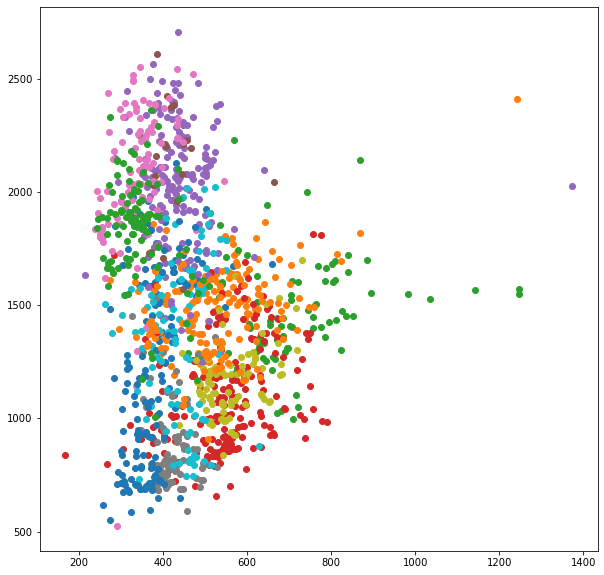

In [6]:
plt.figure(figsize=(10, 10))
for key in f1s:
    plt.scatter(f1s[key], f2s[key])
plt.show()

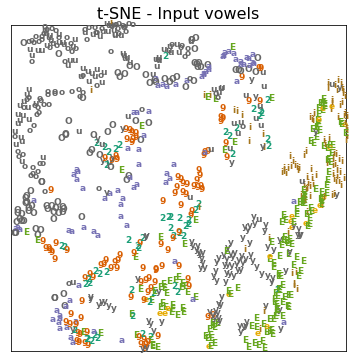

In [102]:
key2idx = {key: i for i, key in enumerate(vowels.keys())}
idx2key = {i: key for key, i in key2idx.items()}

include_nasals = False

def plot_tsne_embeddings(X, y, title):
    y = y.astype(int)
    X = QuantileTransformer(n_quantiles=len(X)).fit_transform(X)
    plt.figure(figsize = (6, 6))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 idx2key[y[i]],
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    return

len_dataset = sum(len(val) for val in vowels.values())
if not include_nasals:
    len_dataset -= sum(len(vowels[k]) for k in vowels.keys() if '~' in k)

formants_tot = torch.empty((len_dataset, 11), dtype=torch.float)
labels_tot = torch.empty(len_dataset, dtype=torch.float)

i = 0
for key, val in vowels.items():
    if '~' in key and not include_nasals:
        continue
    for val2 in val:
        val2 = val2.copy()
        labels_tot[i] = key2idx[key]
        val2[4] = int(val2[4] == 'f')
        val2[5] = int(val2[5] == 'l')
        val2 += [0, 0, 0, 0, 0]
        val2[6] = int(val2[5] == 'm')
        val2[7] = int(val2[5] == 'p')
        val2[8] = int(val2[5] == 's')
        val2[9] = int(val2[5] == 't')
        val2[10] = int(val2[5] == 't1')
        formants_tot[i] = torch.FloatTensor(val2)
        i += 1

indices = torch.randperm(formants_tot.size()[0])
formants_tot = formants_tot[indices]
labels_tot = labels_tot[indices]
        
formants_tot = formants_tot.numpy()
labels_tot = labels_tot.numpy()

formants_TSNE = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(formants_tot)

plot_tsne_embeddings(formants_TSNE, labels_tot, 'Input vowels')

In [211]:
scaler = StandardScaler().fit(formants_tot[:, :4])
formants_tot[:, :4] = scaler.transform(formants_tot[:, :4])

X_train, X_test, y_train, y_test = train_test_split(formants_tot, labels_tot, test_size=0.1, random_state=42)

feature_names = ['F1', 'F2', 'F3', 'F4', 'isF', 'm-', 'l-', 'p-', 's-', 't-', 't1-']
target_names = [idx2key[x] for x in [0, 1, 2, 4, 5, 6, 7, 8, 10, 12]]
classifiers = []

## Decision trees

              precision    recall  f1-score   support

           2     0.5000    0.2000    0.2857        10
           9     0.4706    0.8000    0.5926        10
           a     0.8571    0.8571    0.8571         7
           E     0.7692    0.6667    0.7143        15
           e     0.3333    1.0000    0.5000         1
           i     0.6923    0.7500    0.7200        12
           o     0.8889    0.6667    0.7619        12
           O     0.4286    0.7500    0.5455         4
           u     0.7000    0.7000    0.7000        10
           y     0.7273    0.6154    0.6667        13

    accuracy                         0.6596        94
   macro avg     0.6367    0.7006    0.6344        94
weighted avg     0.6885    0.6596    0.6556        94



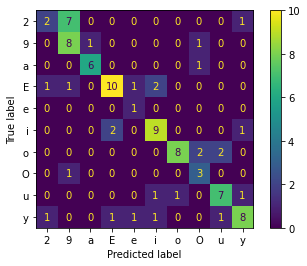

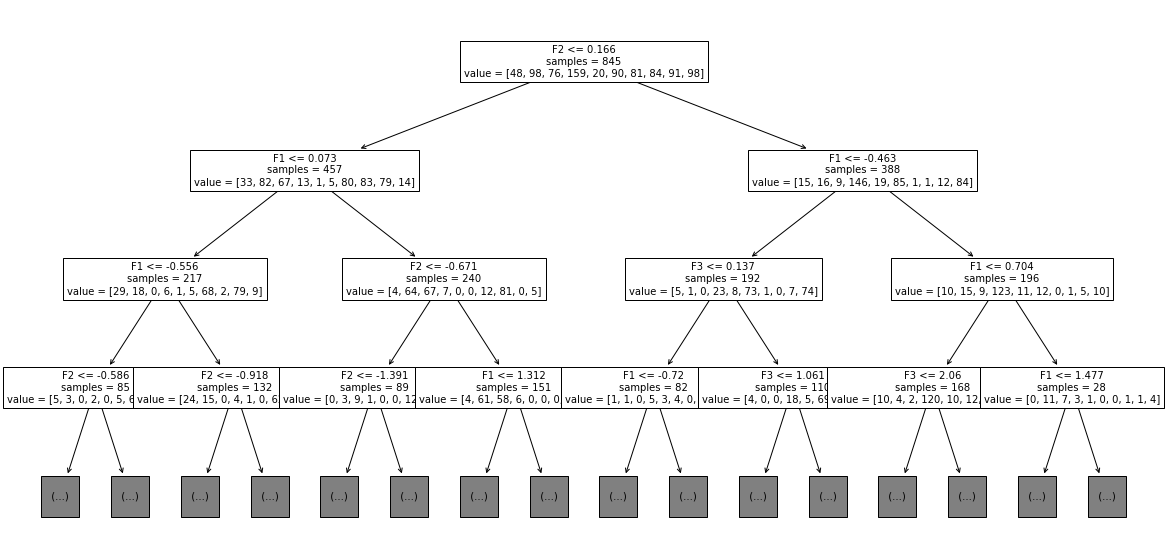

In [212]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
plt.show()
ax = plt.figure(figsize=(20, 10)).gca()
tree.plot_tree(clf, ax=ax, max_depth=3, fontsize=10, impurity=False, feature_names=feature_names)
classifiers.append(('DecisionTree', clf))
plt.show()

## Logistic Regression

              precision    recall  f1-score   support

           2     0.6667    0.2000    0.3077        10
           9     0.5714    0.8000    0.6667        10
           a     0.6667    0.5714    0.6154         7
           E     0.7500    0.8000    0.7742        15
           e     0.0000    0.0000    0.0000         1
           i     0.7857    0.9167    0.8462        12
           o     0.7273    0.6667    0.6957        12
           O     0.4286    0.7500    0.5455         4
           u     0.6250    0.5000    0.5556        10
           y     0.7333    0.8462    0.7857        13

    accuracy                         0.6809        94
   macro avg     0.5955    0.6051    0.5792        94
weighted avg     0.6803    0.6809    0.6608        94



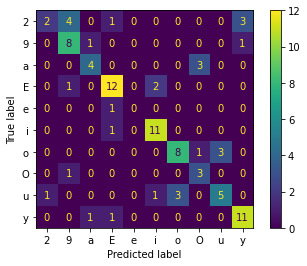

In [213]:
clf = LogisticRegression(random_state=42)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Logistic Regression', clf))
plt.show()

## K Neighbors

              precision    recall  f1-score   support

           2     0.7500    0.6000    0.6667        10
           9     0.5000    0.9000    0.6429        10
           a     1.0000    0.7143    0.8333         7
           E     0.7500    0.8000    0.7742        15
           e     0.0000    0.0000    0.0000         1
           i     0.9000    0.7500    0.8182        12
           o     0.8333    0.8333    0.8333        12
           O     0.8000    1.0000    0.8889         4
           u     0.8571    0.6000    0.7059        10
           y     0.9231    0.9231    0.9231        13

    accuracy                         0.7766        94
   macro avg     0.7314    0.7121    0.7086        94
weighted avg     0.8013    0.7766    0.7763        94



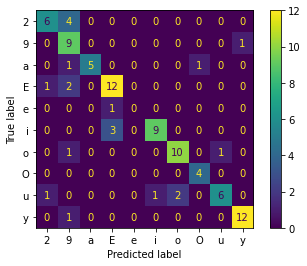

In [214]:
clf = KNeighborsClassifier(n_neighbors=3)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('K Neighbors', clf))
plt.show()

## Multilayer Perceptron

/home/anfasa/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           2     0.8000    0.4000    0.5333        10
           9     0.6000    0.9000    0.7200        10
           a     0.7500    0.8571    0.8000         7
           E     0.8125    0.8667    0.8387        15
           e     0.0000    0.0000    0.0000         1
           i     1.0000    0.9167    0.9565        12
           o     1.0000    0.6667    0.8000        12
           O     0.5714    1.0000    0.7273         4
           u     0.6923    0.9000    0.7826        10
           y     1.0000    0.8462    0.9167        13

    accuracy                         0.7979        94
   macro avg     0.7226    0.7353    0.7075        94
weighted avg     0.8260    0.7979    0.7920        94



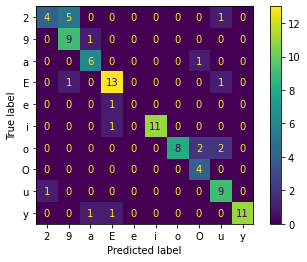

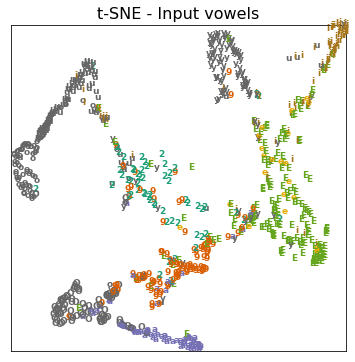

In [215]:
clf = MLPClassifier(random_state=42, hidden_layer_sizes=(25, 25), activation='tanh')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Multilayer Perceptron', clf))
plt.show()

activation = formants_tot
hidden_activation = ACTIVATIONS[clf.activation]
for i in range(clf.n_layers_ - 1):
    activation = np.dot(activation, clf.coefs_[i])
    activation += clf.intercepts_[i]
    if i != clf.n_layers_ - 2:
        hidden_activation(activation)
output_activation = ACTIVATIONS[clf.out_activation_]
output_activation(activation)

formants_TSNE = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(activation)
plot_tsne_embeddings(formants_TSNE, labels_tot, 'Input vowels')

## Random forests

              precision    recall  f1-score   support

           2     0.8000    0.4000    0.5333        10
           9     0.5882    1.0000    0.7407        10
           a     1.0000    0.8571    0.9231         7
           E     0.7059    0.8000    0.7500        15
           e     0.0000    0.0000    0.0000         1
           i     0.8333    0.8333    0.8333        12
           o     0.9000    0.7500    0.8182        12
           O     0.6667    1.0000    0.8000         4
           u     0.8182    0.9000    0.8571        10
           y     1.0000    0.7692    0.8696        13

    accuracy                         0.7872        94
   macro avg     0.7312    0.7310    0.7125        94
weighted avg     0.8098    0.7872    0.7803        94



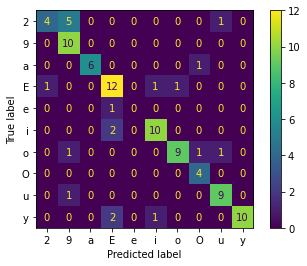

In [216]:
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Random forest', clf))
plt.show()

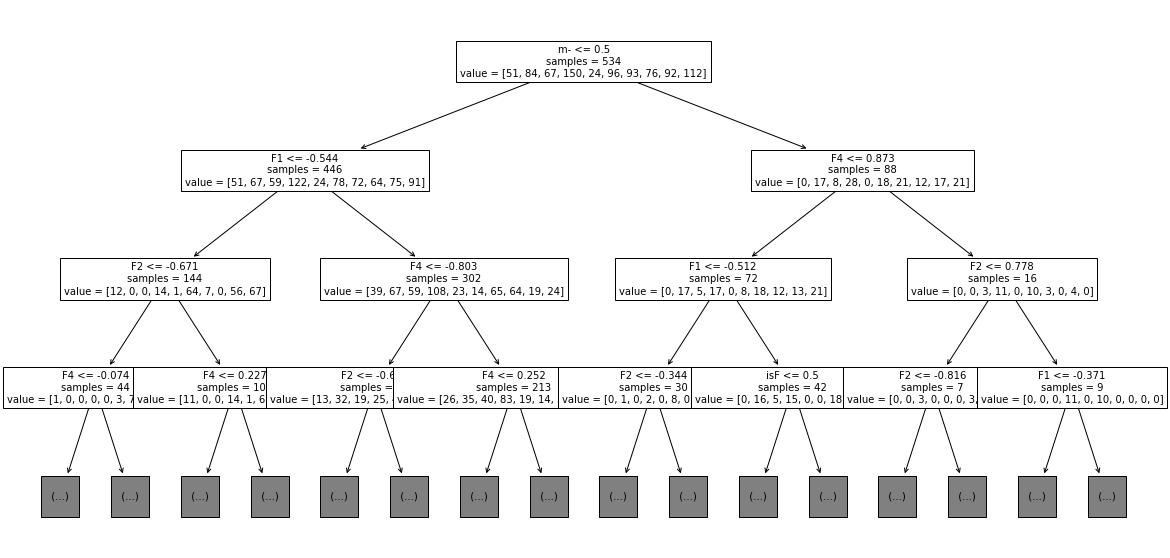

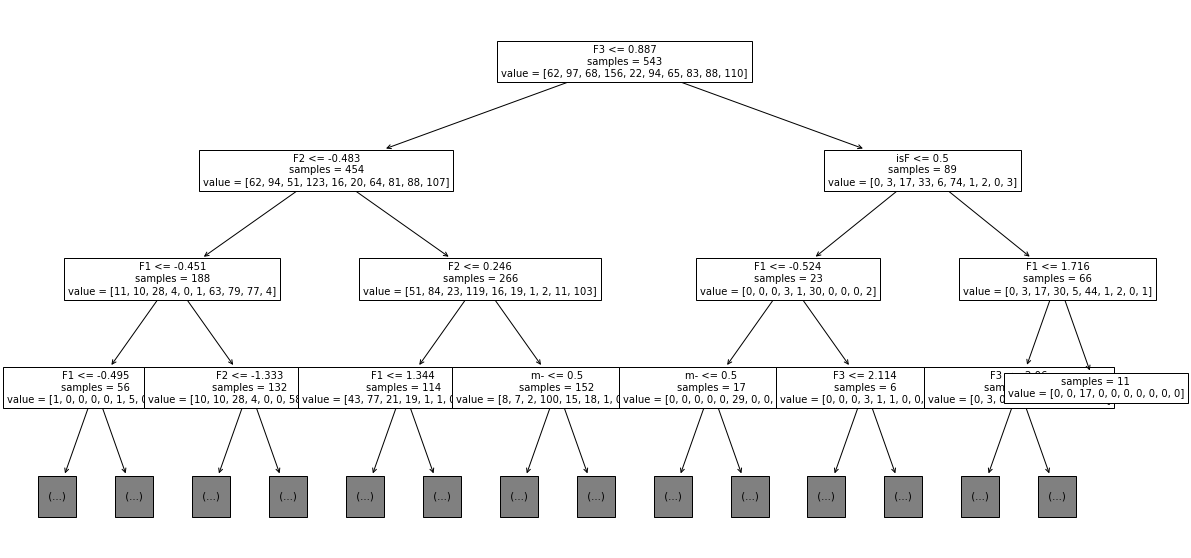

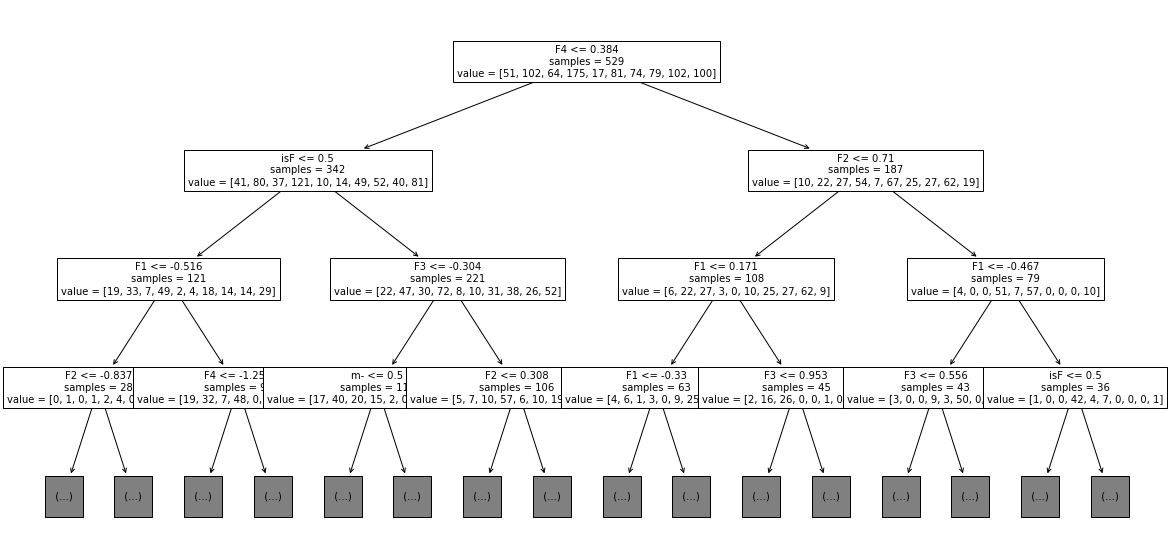

In [217]:
for estimator in clf.estimators_[:3]:
    ax = plt.figure(figsize=(20, 10)).gca()
    tree.plot_tree(estimator, ax=ax, max_depth=3, fontsize=10, impurity=False, feature_names=feature_names)
    plt.show()

## Bagging

              precision    recall  f1-score   support

           2     0.8000    0.8000    0.8000        10
           9     0.7000    0.7000    0.7000        10
           a     0.6667    0.8571    0.7500         7
           E     0.7222    0.8667    0.7879        15
           e     0.0000    0.0000    0.0000         1
           i     0.8333    0.8333    0.8333        12
           o     0.8889    0.6667    0.7619        12
           O     0.6667    1.0000    0.8000         4
           u     0.8889    0.8000    0.8421        10
           y     0.9091    0.7692    0.8333        13

    accuracy                         0.7872        94
   macro avg     0.7076    0.7293    0.7109        94
weighted avg     0.7930    0.7872    0.7837        94



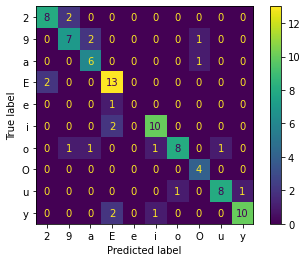

In [218]:
clf = BaggingClassifier(random_state=42, n_estimators=10)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Bagging', clf))
plt.show()

## Extra trees

              precision    recall  f1-score   support

           2     0.8000    0.4000    0.5333        10
           9     0.5625    0.9000    0.6923        10
           a     0.7500    0.8571    0.8000         7
           E     0.7647    0.8667    0.8125        15
           e     0.0000    0.0000    0.0000         1
           i     1.0000    0.7500    0.8571        12
           o     0.8333    0.8333    0.8333        12
           O     0.8000    1.0000    0.8889         4
           u     0.8000    0.8000    0.8000        10
           y     1.0000    0.9231    0.9600        13

    accuracy                         0.7979        94
   macro avg     0.7311    0.7330    0.7178        94
weighted avg     0.8143    0.7979    0.7911        94



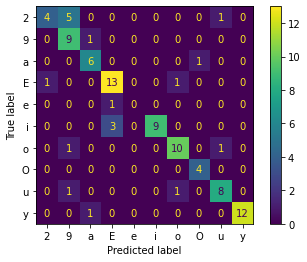

In [219]:
clf = ExtraTreesClassifier(random_state=42, n_estimators=500)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Extra trees', clf))
plt.show()

## Stacking

              precision    recall  f1-score   support

           2     0.6667    0.2000    0.3077        10
           9     0.5333    0.8000    0.6400        10
           a     0.8571    0.8571    0.8571         7
           E     0.7059    0.8000    0.7500        15
           e     0.0000    0.0000    0.0000         1
           i     0.6923    0.7500    0.7200        12
           o     1.0000    0.6667    0.8000        12
           O     0.5000    1.0000    0.6667         4
           u     0.8182    0.9000    0.8571        10
           y     0.9091    0.7692    0.8333        13

    accuracy                         0.7234        94
   macro avg     0.6683    0.6743    0.6432        94
weighted avg     0.7542    0.7234    0.7132        94



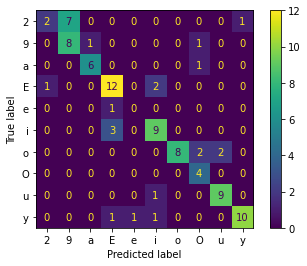

In [220]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(classifiers, cv='prefit')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
plt.show()